# Do Interictal Discharges Affect Functional Connectivity

author: Jeni Stiso (jeni.stiso@gmail.com)

words

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from statsmodels.stats.anova import AnovaRM
import palettable
import statsmodels.api as sm
from sklearn.metrics.pairwise import euclidean_distances

%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
sns.set_context('poster')
sns.set_style("whitegrid")

In [4]:
# directories - point this at you RAM data
RAM_dir = '/Volumes/bassett-data/Jeni/RAM/'
parcel_dir = '/Users/stiso/Documents/parcellations/'
win = 1
detector = '' # '_delphos' or ''

# load data
net_data = pd.read_csv(f'{RAM_dir}group_analysis/win_{win}/network_stats{detector}.csv', index_col=0)
node_data = pd.read_csv(f'{RAM_dir}group_analysis/win_{win}/node_stats{detector}.csv', index_col=0)

# drop duplicates
net_data.drop_duplicates(inplace=True)
node_data.drop_duplicates(inplace=True)

Check the data

In [5]:
net_data.head(10)

band_measure  n_tp  str_beta_bin  str_beta_num  str_beta_spr  \
1         alpha_aec   107     -0.001170     -0.003834     -0.000906   
2   alpha_aec_ortho   107      0.003289      0.001749     -0.000120   
3         alpha_coh   107     -0.002831     -0.001307     -0.000162   
4      alpha_im_coh   107     -0.002251     -0.001216     -0.000052   
5        alpha_iplv   107     -0.011551     -0.018571     -0.000731   
6         alpha_plv   107     -0.005822     -0.007193     -0.001030   
7          beta_aec   107      0.003067      0.000166      0.000331   
8    beta_aec_ortho   107      0.000570     -0.002487      0.000517   
9          beta_coh   107      0.004299      0.004198      0.000761   
10      beta_im_coh   107      0.002699      0.002134      0.000615   

    ti_beta_bin  ti_beta_num  ti_beta_spr  str_soz_beta_bin  str_soz_beta_num  \
1     -0.003215     0.007433     0.001236         -0.000725         -0.001365   
2     -0.038618    -0.040827    -0.004130          0.010050          0.014568   
3      0.087585     0.122493    -0.000073         -0.008283         -0.009722   
4      0.007866     0.010105    -0.000839         -0.006486         -0.006336   
5      0.035004     0.052945     0.002363         -0.017375         -0.029580   
6      0.095681     0.141000     0.008685         -0.005493         -0.010452   
7     -0.015171     0.013705    -0.004430          0.002493          0.002855   
8      0.008797     0.038698     0.000097         -0.002593         -0.001835   
9     -0.056966    -0.043601    -0.016674          0.001811          0.000839   
10    -0.019914    -0.036505    -0.007572          0.001734          0.000889   

    ...   str_not_spike_beta_bin  fc_measure  str_not_spike_beta_num  \
1   ...                 0.000924         aec               -0.001389   
2   ...                 0.005191   aec_ortho                0.003880   
3   ...                -0.003665         coh               -0.002760   
4   ...                -0.002827      im_coh               -0.002087   
5   ...                -0.012845        iplv               -0.020457   
6   ...                -0.007858         plv               -0.009864   
7   ...                 0.003022         aec               -0.000280   
8   ...                -0.000020   aec_ortho               -0.003504   
9   ...                 0.002066         coh                0.001293   
10  ...                 0.001274      im_coh                0.000112   

    str_not_spike_beta_spr   band    subj  hand   age gender  race  
1                -0.000820  alpha  R1170J     R  20.0      M   2.0  
2                 0.000028  alpha  R1170J     R  20.0      M   2.0  
3                -0.000223  alpha  R1170J     R  20.0      M   2.0  
4                -0.000075  alpha  R1170J     R  20.0      M   2.0  
5                -0.000749  alpha  R1170J     R  20.0      M   2.0  
6                -0.001123  alpha  R1170J     R  20.0      M   2.0  
7                 0.000447   beta  R1170J     R  20.0      M   2.0  
8                 0.000536   beta  R1170J     R  20.0      M   2.0  
9                 0.000551   beta  R1170J     R  20.0      M   2.0  
10                0.000493   beta  R1170J     R  20.0      M   2.0  

[10 rows x 27 columns]

In [6]:
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4860 entries, 1 to 4950
Data columns (total 27 columns):
band_measure              4860 non-null object
n_tp                      4860 non-null int64
str_beta_bin              4380 non-null float64
str_beta_num              4830 non-null float64
str_beta_spr              4830 non-null float64
ti_beta_bin               4380 non-null float64
ti_beta_num               4830 non-null float64
ti_beta_spr               4830 non-null float64
str_soz_beta_bin          3150 non-null float64
str_soz_beta_num          3450 non-null float64
str_soz_beta_spr          3450 non-null float64
str_not_soz_beta_num      3438 non-null float64
str_spike_beta_num        3330 non-null float64
str_not_soz_beta_spr      3438 non-null float64
str_not_soz_beta_bin      3140 non-null float64
str_spike_beta_bin        3030 non-null float64
str_spike_beta_spr        3330 non-null float64
str_not_spike_beta_bin    3022 non-null float64
fc_measure                4860 n

In [7]:
net_data.describe()

n_tp  str_beta_bin  str_beta_num  str_beta_spr  ti_beta_bin  \
count  4860.000000   4380.000000   4830.000000   4830.000000  4380.000000   
mean    910.481481      0.002574      0.000756      0.001026    -0.009566   
std     974.877168      0.047076      0.028726      0.032933     0.132506   
min      15.000000     -0.486796     -0.367578     -0.117907    -2.628202   
25%     248.000000     -0.000830     -0.002504     -0.000227    -0.024034   
50%     630.000000      0.000820      0.000107      0.000258    -0.003317   
75%    1098.000000      0.003640      0.002873      0.001120     0.010785   
max    5613.000000      2.852347      1.329133      2.274297     2.311621   

       ti_beta_num  ti_beta_spr  str_soz_beta_bin  str_soz_beta_num  \
count  4830.000000  4830.000000       3150.000000       3450.000000   
mean      0.003796    -0.001242          0.002243          0.000658   
std       0.303598     0.053387          0.018673          0.033463   
min      -5.638291    -2.009684         -0.234594         -0.697265   
25%      -0.018479    -0.005684         -0.001588         -0.003530   
50%       0.001523    -0.000415          0.001152          0.000236   
75%       0.023385     0.003468          0.005434          0.004104   
max       9.589825     1.126187          0.482665          0.347040   

       str_soz_beta_spr     ...       str_spike_beta_num  \
count       3450.000000     ...              3330.000000   
mean           0.000890     ...                 0.001306   
std            0.006270     ...                 0.029667   
min           -0.092586     ...                -0.511652   
25%           -0.000327     ...                -0.002663   
50%            0.000334     ...                 0.000574   
75%            0.001680     ...                 0.004401   
max            0.117418     ...                 0.371266   

       str_not_soz_beta_spr  str_not_soz_beta_bin  str_spike_beta_bin  \
count           3438.000000           3140.000000         3030.000000   
mean               0.000526              0.002037            0.002438   
std                0.004299              0.016995            0.017393   
min               -0.028010             -0.393918           -0.219040   
25%               -0.000245             -0.000907           -0.001212   
50%                0.000201              0.000684            0.001153   
75%                0.000948              0.003384            0.005118   
max                0.164639              0.545540            0.428060   

       str_spike_beta_spr  str_not_spike_beta_bin  str_not_spike_beta_num  \
count         3330.000000             3022.000000             3320.000000   
mean             0.000721                0.002155                0.001219   
std              0.005450                0.017535                0.021218   
min             -0.054062               -0.382893               -0.364644   
25%             -0.000332               -0.000939               -0.002451   
50%              0.000371                0.000630                0.000101   
75%              0.001574                0.003457                0.002962   
max              0.112021                0.551421                0.293906   

       str_not_spike_beta_spr          age         race  
count             3320.000000  4830.000000  4650.000000  
mean                 0.000390    36.018634     2.993548  
std                  0.004494    11.766243     1.210285  
min                 -0.037318    16.000000     1.000000  
25%                 -0.000318    27.000000     2.000000  
50%                  0.000148    34.000000     4.000000  
75%                  0.000857    44.000000     4.000000  
max                  0.166146    66.000000     7.000000  

[8 rows x 21 columns]

In [8]:
node_data.tail(10)

elec     band_measure  n_tp  elec_spike  elec_in_soz  \
524091  RPT4           hg_aec  5613    0.002138            1   
524092  RPT4     hg_aec_ortho  5613    0.002138            1   
524093  RPT4           hg_coh  5613    0.002138            1   
524094  RPT4        hg_im_coh  5613    0.002138            1   
524095  RPT4        theta_aec  5613    0.002138            1   
524096  RPT4  theta_aec_ortho  5613    0.002138            1   
524097  RPT4        theta_coh  5613    0.002138            1   
524098  RPT4     theta_im_coh  5613    0.002138            1   
524099  RPT4       theta_iplv  5613    0.002138            1   
524100  RPT4        theta_plv  5613    0.002138            1   

        str_soz_beta_bin  str_not_soz_beta_bin  str_spike_beta_bin  \
524091          0.000068                   NaN            0.001288   
524092         -0.000222                   NaN           -0.000687   
524093          0.002401                   NaN            0.004151   
524094          0.001282                   NaN            0.002103   
524095         -0.009824                   NaN           -0.001754   
524096         -0.007596                   NaN            0.001871   
524097          0.000031                   NaN            0.001573   
524098         -0.000594                   NaN           -0.000700   
524099          0.004052                   NaN            0.000108   
524100          0.001640                   NaN           -0.010828   

        str_not_spike_beta_bin  str_beta_bin  ...        region        x  \
524091               -0.000061      0.000068  ...   postcentral  44.7886   
524092               -0.000173     -0.000222  ...   postcentral  44.7886   
524093                0.002201      0.002401  ...   postcentral  44.7886   
524094                0.001183      0.001282  ...   postcentral  44.7886   
524095               -0.010564     -0.009824  ...   postcentral  44.7886   
524096               -0.008427     -0.007596  ...   postcentral  44.7886   
524097               -0.000142      0.000031  ...   postcentral  44.7886   
524098               -0.000587     -0.000594  ...   postcentral  44.7886   
524099                0.004489      0.004052  ...   postcentral  44.7886   
524100                0.002977      0.001640  ...   postcentral  44.7886   

              y          z  type    subj  hand   age  gender  race  
524091 -32.1611  67.016101     S  R1001P     R  48.0       F   1.0  
524092 -32.1611  67.016101     S  R1001P     R  48.0       F   1.0  
524093 -32.1611  67.016101     S  R1001P     R  48.0       F   1.0  
524094 -32.1611  67.016101     S  R1001P     R  48.0       F   1.0  
524095 -32.1611  67.016101     S  R1001P     R  48.0       F   1.0  
524096 -32.1611  67.016101     S  R1001P     R  48.0       F   1.0  
524097 -32.1611  67.016101     S  R1001P     R  48.0       F   1.0  
524098 -32.1611  67.016101     S  R1001P     R  48.0       F   1.0  
524099 -32.1611  67.016101     S  R1001P     R  48.0       F   1.0  
524100 -32.1611  67.016101     S  R1001P     R  48.0       F   1.0  

[10 rows x 35 columns]

In [9]:
node_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510810 entries, 1 to 524100
Data columns (total 35 columns):
elec                      510810 non-null object
band_measure              510810 non-null object
n_tp                      510810 non-null int64
elec_spike                510810 non-null float64
elec_in_soz               510810 non-null int64
str_soz_beta_bin          304410 non-null float64
str_not_soz_beta_bin      278753 non-null float64
str_spike_beta_bin        290190 non-null float64
str_not_spike_beta_bin    253713 non-null float64
str_beta_bin              443821 non-null float64
str_soz_beta_num          333690 non-null float64
str_not_soz_beta_num      305558 non-null float64
str_spike_beta_num        319590 non-null float64
str_beta_num              488340 non-null float64
str_not_spike_beta_num    279362 non-null float64
ti_beta_bin               443820 non-null float64
ti_beta_num               488340 non-null float64
ti_beta_spr               488340 non-null flo

In [10]:
node_data.describe()

n_tp     elec_spike    elec_in_soz  str_soz_beta_bin  \
count  510810.000000  510810.000000  510810.000000     304410.000000   
mean      782.838257       0.020250       0.057967          0.002388   
std       868.646948       0.045059       0.233681          0.036361   
min        11.000000       0.000000       0.000000         -0.830729   
25%       166.000000       0.000000       0.000000         -0.005045   
50%       520.000000       0.003165       0.000000          0.001209   
75%       960.000000       0.018051       0.000000          0.009430   
max      5613.000000       0.600000       1.000000          0.813599   

       str_not_soz_beta_bin  str_spike_beta_bin  str_not_spike_beta_bin  \
count         278753.000000       290190.000000           253713.000000   
mean               0.002360            0.002583                0.002691   
std                0.023202            0.031877                0.024395   
min               -0.875766           -0.761630               -0.879614   
25%               -0.002226           -0.004253               -0.002232   
50%                0.000774            0.001270                0.000799   
75%                0.005209            0.008638                0.005600   
max                0.793041            0.628469                0.801552   

        str_beta_bin  str_soz_beta_num  str_not_soz_beta_num      ...        \
count  443821.000000     333690.000000         305558.000000      ...         
mean        0.003143          0.001422              0.001539      ...         
std         0.064968          0.095202              0.039847      ...         
min        -4.228341         -3.325991             -1.144812      ...         
25%        -0.002397         -0.007020             -0.003367      ...         
50%         0.000911          0.000433              0.000377      ...         
75%         0.005731          0.008823              0.004850      ...         
max         5.398142          2.439457              1.523325      ...         

        str_beta_spr  str_soz_beta_spr  str_not_soz_beta_spr  \
count  488340.000000     333690.000000         305558.000000   
mean        0.000735          0.000996              0.000713   
std         0.012958          0.020106              0.008509   
min        -0.797629         -0.666208             -0.492310   
25%        -0.000543         -0.001188             -0.000536   
50%         0.000249          0.000300              0.000206   
75%         0.001575          0.002496              0.001392   
max         2.336956          0.700636              0.250058   

       str_spike_beta_spr  str_not_spike_beta_spr              x  \
count       319590.000000           279362.000000  394350.000000   
mean             0.000902                0.000663      -6.845191   
std              0.016128                0.009289      46.754199   
min             -0.570244               -0.548443    -165.993000   
25%             -0.001006               -0.000571     -45.527600   
50%              0.000327                0.000184     -15.858700   
75%              0.002329                0.001390      34.293900   
max              0.549138                0.639080     173.816000   

                   y              z            age           race  
count  394350.000000  394350.000000  498000.000000  485100.000000  
mean       -6.526295       3.095124      36.268554       2.930921  
std        36.656852      47.574078      11.729515       1.228246  
min      -143.909000    -402.070855      16.000000       1.000000  
25%       -30.082100     -19.709704      27.000000       2.000000  
50%        -7.849940       0.464097      36.000000       4.000000  
75%        16.487300      31.827162      44.000000       4.000000  
max       207.770000      93.980799      66.000000       7.000000  

[8 rows x 26 columns]

Basic EDA: check distribution of demographics, replace NaNs where appropriate, etc

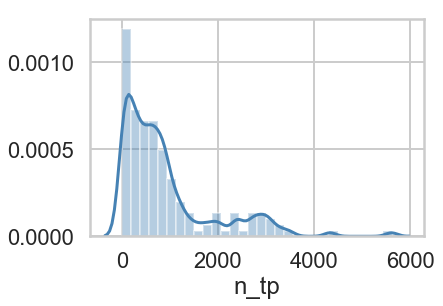

In [11]:
sns.distplot(net_data['n_tp'], bins=30, color='steelblue')

In [12]:
net_data.subj.nunique()

160

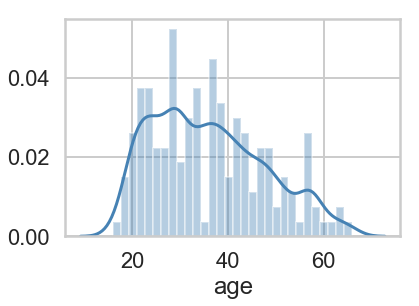

In [13]:
net_data['age'].replace(to_replace=0, value=None, inplace=True)
sns.distplot(net_data['age'].dropna(), bins=30, color='steelblue')
mean_age = net_data['age'].mean()

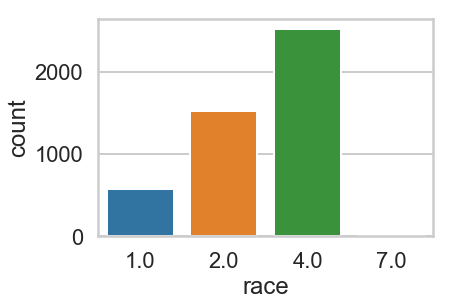

In [14]:
sns.countplot(data=net_data, x='race', )
mean_race = 4

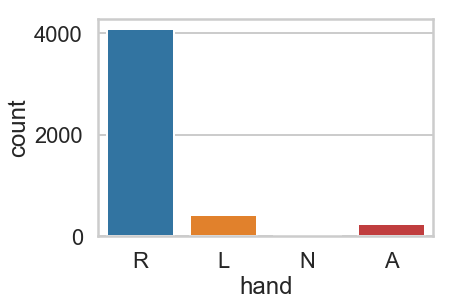

In [15]:
sns.countplot(data=net_data, x='hand', )
mean_hand = 'R'

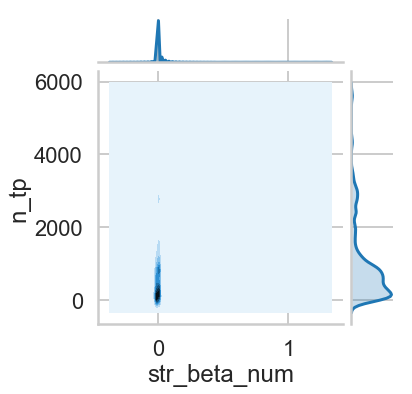

In [16]:
sns.jointplot(data=net_data, x='str_beta_num', y='n_tp', kind='kde' )

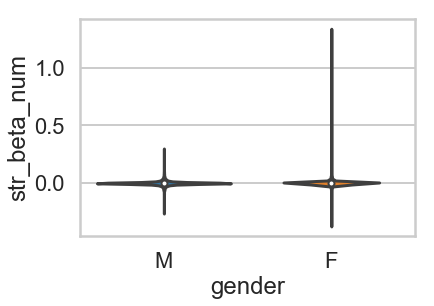

In [17]:
sns.violinplot(data=net_data, x='gender', y='str_beta_num', cut=True)

In [18]:
# add means for null values
net_data.loc[net_data['age'].isnull(), 'age'] = mean_age
net_data.loc[net_data['race'].isnull(), 'race'] = mean_race
net_data.loc[net_data['hand'].isnull(), 'hand'] = mean_hand

# same for node data
node_data.loc[node_data['age'].isnull(), 'age'] = mean_age
node_data.loc[node_data['race'].isnull(), 'race'] = mean_race
node_data.loc[node_data['hand'].isnull(), 'hand'] = mean_hand

In [19]:
# check for duplicates, these two numbers should match
print(net_data.dropna().subj.nunique())
print(net_data[net_data.band_measure == 'theta_plv'].dropna().subj.count())

89
89


In [20]:
# some subjects have ambidextrous and right handed answers in demographics, 
# take the one that is used in the net data (whatever they said first)
dems = ['race', 'hand', 'gender', 'age']
subjs = node_data['subj'].unique()
for s in subjs:
    if any(node_data.loc[node_data['subj'] == s, dems].nunique() > 1):
        correct_dems = net_data.loc[net_data.subj == s, dems]
        node_data.loc[node_data['subj'] == s, dems] = np.tile(correct_dems.iloc[0,:].values, 
                                                              (sum(node_data['subj'] == s),1))
node_data.drop(index=node_data.index[node_data.duplicated()], inplace=True)
node_data.dropna(axis=0).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156542 entries, 1 to 524084
Data columns (total 35 columns):
elec                      156542 non-null object
band_measure              156542 non-null object
n_tp                      156542 non-null int64
elec_spike                156542 non-null float64
elec_in_soz               156542 non-null int64
str_soz_beta_bin          156542 non-null float64
str_not_soz_beta_bin      156542 non-null float64
str_spike_beta_bin        156542 non-null float64
str_not_spike_beta_bin    156542 non-null float64
str_beta_bin              156542 non-null float64
str_soz_beta_num          156542 non-null float64
str_not_soz_beta_num      156542 non-null float64
str_spike_beta_num        156542 non-null float64
str_beta_num              156542 non-null float64
str_not_spike_beta_num    156542 non-null float64
ti_beta_bin               156542 non-null float64
ti_beta_num               156542 non-null float64
ti_beta_spr               156542 non-null flo

In [21]:
# drop nulls
cols = ['str_beta_bin','str_beta_num','str_beta_spr']

keep_subj = net_data.pivot_table(index='subj', columns=['fc_measure'],
                     values=['str_beta_bin','str_beta_num','str_beta_spr'], 
                                 aggfunc = lambda x: any(np.isnan(x))).any(axis=1)
keep_subj = keep_subj.index[[not x for x in keep_subj.values]]

net_data = net_data[[x in keep_subj for x in net_data.subj]]
node_data = node_data[[x in keep_subj for x in node_data.subj]]

In [22]:
net_data.subj.nunique()

143

## Effects on Network Measures

visualize how much spikes regularly change network strength.

In [23]:
# remove outliers 3 std
group_mean = net_data.groupby('band_measure').mean()
group_sd = net_data.groupby('band_measure').std()
bm = group_mean.index
col = group_mean.columns[1:-2]
for b in bm:
    for c in col:
        idx = (net_data['band_measure'] == b) & ((net_data.loc[:,c] > (group_mean.loc[b,c] + 3*group_sd.loc[b,c])) |
                                                 (net_data.loc[:,c] < (group_mean.loc[b,c] - 3*group_sd.loc[b,c])))
        net_data.loc[idx,c] = np.nan
net_data.head()

band_measure  n_tp  str_beta_bin  str_beta_num  str_beta_spr  \
1        alpha_aec   107     -0.001170     -0.003834     -0.000906   
2  alpha_aec_ortho   107      0.003289      0.001749     -0.000120   
3        alpha_coh   107     -0.002831     -0.001307     -0.000162   
4     alpha_im_coh   107     -0.002251     -0.001216     -0.000052   
5       alpha_iplv   107     -0.011551     -0.018571     -0.000731   

   ti_beta_bin  ti_beta_num  ti_beta_spr  str_soz_beta_bin  str_soz_beta_num  \
1    -0.003215     0.007433     0.001236         -0.000725         -0.001365   
2    -0.038618    -0.040827    -0.004130          0.010050          0.014568   
3     0.087585     0.122493    -0.000073         -0.008283         -0.009722   
4     0.007866     0.010105    -0.000839         -0.006486         -0.006336   
5     0.035004     0.052945     0.002363         -0.017375         -0.029580   

   ...   str_not_spike_beta_bin  fc_measure  str_not_spike_beta_num  \
1  ...                 0.000924         aec               -0.001389   
2  ...                 0.005191   aec_ortho                0.003880   
3  ...                -0.003665         coh               -0.002760   
4  ...                -0.002827      im_coh               -0.002087   
5  ...                -0.012845        iplv               -0.020457   

   str_not_spike_beta_spr   band    subj  hand   age gender  race  
1               -0.000820  alpha  R1170J     R  20.0      M   2.0  
2                0.000028  alpha  R1170J     R  20.0      M   2.0  
3               -0.000223  alpha  R1170J     R  20.0      M   2.0  
4               -0.000075  alpha  R1170J     R  20.0      M   2.0  
5               -0.000749  alpha  R1170J     R  20.0      M   2.0  

[5 rows x 27 columns]

In [24]:
# save
# rename stuff to make it pretty
net_data.replace({'band':{'theta':'Theta', 'alpha':'Alpha','beta':'Beta', 'gamma':'Gamma',
                         'hg':'High Gamma', 'broadband':'LFP'}}, inplace=True)
net_data.rename(columns={'band':'Frequency Band', 'fc_measure':'Measure'}, inplace=True)
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_data_clean{detector}.csv')

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


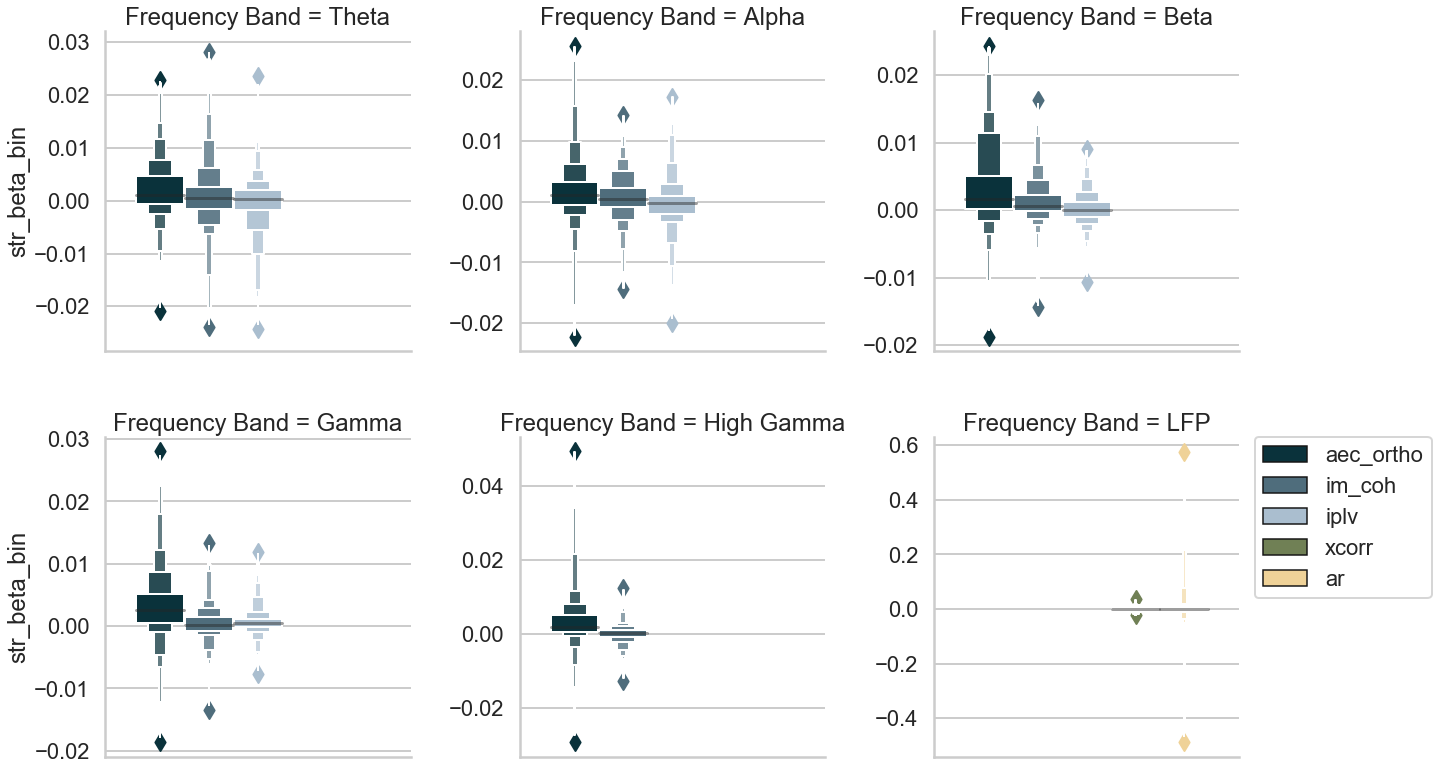

In [24]:
# parameters
supp_flag = True # if true, includes orthogonal AEC
yvar = 'bin'

if (not supp_flag):
    h_order = ['aec',  'coh', 'plv', 'xcorr', 'ar']
    supp_ext = ''
    # colors
    colors = ['#453947','#84476f', '#BB84C2', '#72874E', '#FED789']
    custom_palette = sns.set_palette(sns.color_palette(colors))
else:
    h_order = ['aec_ortho', 'im_coh', 'iplv', 'xcorr', 'ar']
    supp_ext = '_supp'
    # color pallette
    colors = ['#023743',  '#476f84', '#A4BED5', '#72874E', '#FED789']

    
g = sns.FacetGrid(data=net_data, col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=6, 
                 col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
g.map(sns.boxenplot, 'Frequency Band', 'str_beta_' + yvar, 'Measure', palette = sns.color_palette(colors), 
      hue_order=h_order)

g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
for ax in g.axes:
    ax.axes.xaxis.set_visible(False)
if (supp_flag):  
    g.savefig(f"../img/net_{yvar}_str{detector}_vc.eps")
else:
    g.savefig(f"../img/net_{yvar}_str{detector}.eps")

In [25]:
# parameters
supp_flag = True # if true, includes orthogonal AEC
yvar = 'spr'

if (not supp_flag):
    h_order = ['aec',  'coh', 'plv', 'xcorr', 'ar']
    supp_ext = ''
    # colors
    colors = ['#453947','#84476f', '#BB84C2', '#72874E', '#FED789']
    custom_palette = sns.set_palette(sns.color_palette(colors))
else:
    h_order = ['aec_ortho', 'im_coh', 'iplv', 'xcorr', 'ar']
    supp_ext = '_supp'
    # color pallette
    colors = ['#023743',  '#476f84', '#A4BED5', '#72874E', '#FED789']

    
g = sns.FacetGrid(data=net_data, col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=6, 
                 col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
g.map(sns.boxenplot, 'Frequency Band', 'ti_beta_' + yvar, 'Measure', palette = sns.color_palette(colors), 
      hue_order=h_order)

g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
for ax in g.axes:
    ax.axes.xaxis.set_visible(False)
if (supp_flag):  
    g.savefig(f"../img/net_{yvar}_ti{detector}_vc.eps")
else:
    g.savefig(f"../img/net_{yvar}_ti{detector}.eps")

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


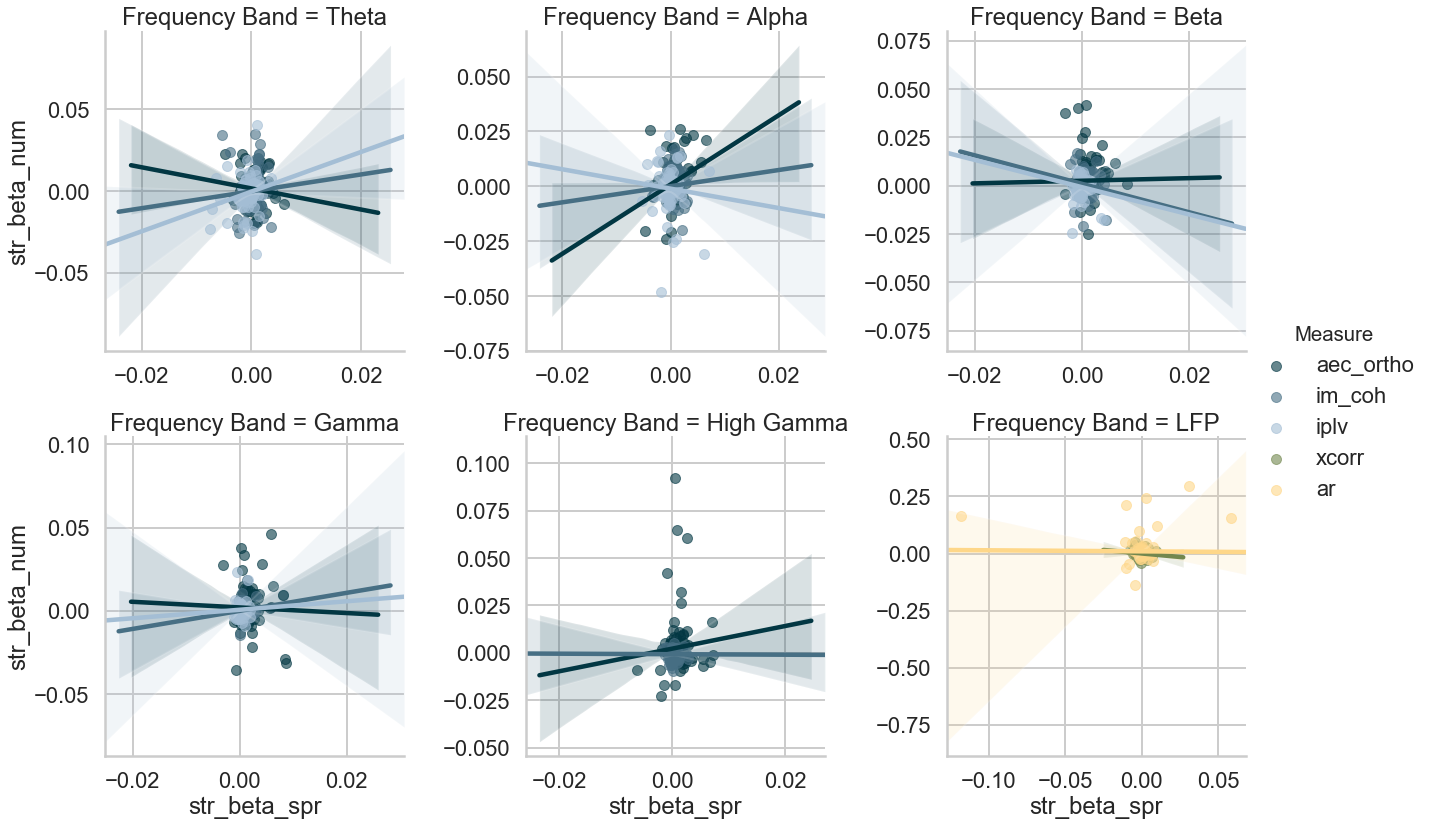

In [26]:
var1 = 'spr'
var2 = 'num'
sns.lmplot(data=net_data, x='str_beta_' + var1, y='str_beta_' + var2, hue='Measure', col="Frequency Band", 
           col_wrap=3, height=6, sharex=False, sharey=False, 
           col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'],
           palette=sns.color_palette(colors), 
           scatter_kws={'s':100, 'alpha':.6}, 
           hue_order=h_order)
plt.savefig(f"../img/{var1}_{var2}.pdf")

Is this because of volume conduction?

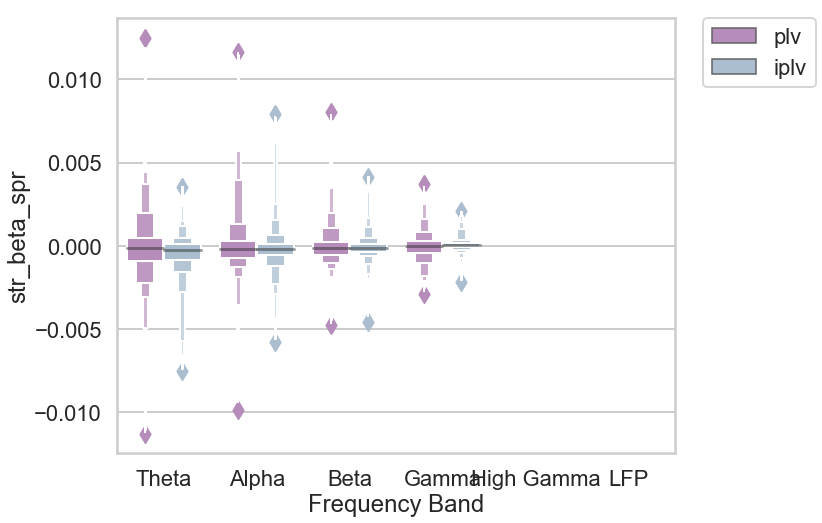

In [549]:

# parameters
y_var = 'spr'
m = 'plv'

if (m == 'coh'):
    h_order = ['coh', 'im_coh']
    # color pallette
    colors = ['#84476f', '#476f84']
elif (m=='aec'):
    h_order = ['aec', 'aec_ortho']
    colors = ['#453947', '#023732']
else:
    h_order = ['plv', 'iplv']
    colors = ['#BB84C2', '#A4BED5']
custom_palette = sns.set_palette(sns.color_palette(colors))

fig = plt.figure(figsize=(10,8))
sns.boxenplot( data=net_data[(net_data['Measure'] == h_order[0]) | (net_data['Measure'] == h_order[1])]
              , x="Frequency Band", y='str_beta_' + y_var, hue='Measure', 
            order=['Theta','Alpha','Beta','Gamma','High Gamma','LFP'], hue_order=h_order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ylim(-2,2)
plt.savefig(f"../img/volume_conduction_{y_var}_{m}{detector}.eps")


In [574]:
# initialize lists for later - need to keep trake of all predictors

y = []
label = []
rval = []
pval = []
ci_up = []
ci_lo = []


In [583]:
# get correlation matrix for all str effects
yvar = 'spr' 
net_data = net_data[(net_data['Measure'] != 'aec') & (net_data['Measure'] != 'coh') & (net_data['Measure'] != 'plv')]
net_data = net_data.assign(measure_band = net_data['Measure'] + '_' + net_data['Frequency Band'])
band_data = net_data.pivot_table(index = 'subj', columns='band_measure', 
                          values = ['str_beta_' + yvar]) # default agg func is mean
band_data.columns = [col[1] for col in band_data.columns]
cols = band_data.columns
cols = np.concatenate((cols[-3:].values, cols[:6].values, cols[8:-3].values, cols[6:8].values))
band_data = band_data[cols]
band_data.head()

theta_aec_ortho  theta_im_coh  theta_iplv  alpha_aec_ortho  \
subj                                                                 
R1001P         0.000195      0.000956   -0.000282         0.000541   
R1002P         0.000688      0.001667    0.000257        -0.000139   
R1003P        -0.000114      0.001628    0.000309         0.000030   
R1004D              NaN           NaN    0.001980              NaN   
R1008J         0.000039      0.000317   -0.000008         0.000108   

        alpha_im_coh  alpha_iplv  beta_aec_ortho  beta_im_coh  beta_iplv  \
subj                                                                       
R1001P      0.000487   -0.000002        0.000522     0.000377  -0.000374   
R1002P      0.000695    0.000086        0.000774     0.000643  -0.000660   
R1003P      0.000526   -0.000506        0.000247     0.000332  -0.000100   
R1004D           NaN    0.007111             NaN          NaN        NaN   
R1008J      0.000430   -0.000159        0.000393     0.000357  -0.000031   

        gamma_aec_ortho  gamma_im_coh  gamma_iplv  hg_aec_ortho  hg_im_coh  \
subj                                                                         
R1001P         0.000547      0.000465   -0.000173      0.000286   0.000494   
R1002P         0.001760      0.000566    0.000188      0.001618   0.000307   
R1003P         0.000804      0.000058   -0.000013      0.000584   0.000021   
R1004D              NaN           NaN         NaN     -0.006147   0.002101   
R1008J         0.000706      0.000253   -0.000038      0.000098   0.000085   

        broadband_ar  broadband_xcorr  
subj                                   
R1001P     -0.000069        -0.000543  
R1002P      0.002263         0.009703  
R1003P     -0.000073        -0.001101  
R1004D      0.003089        -0.000223  
R1008J     -0.000060        -0.000160

In [584]:
meas_data = net_data.pivot_table(index = 'subj', columns='measure_band', 
                                 values = ['str_beta_' + yvar])
meas_data.columns = [col[1] for col in meas_data.columns]
cols = meas_data.columns
cols = np.concatenate((cols[4:-11].values, cols[0:4].values, cols[10:-5].values, cols[6:10].values, 
                       cols[14:15].values, cols[11:14].values, cols[15:16].values, cols[5:-10].values))
meas_data = meas_data[cols]
meas_data.head()

aec_ortho_Theta  aec_ortho_Alpha  aec_ortho_Beta  aec_ortho_Gamma  \
subj                                                                        
R1001P         0.000195         0.000541        0.000522         0.000547   
R1002P         0.000688        -0.000139        0.000774         0.001760   
R1003P        -0.000114         0.000030        0.000247         0.000804   
R1004D              NaN              NaN             NaN              NaN   
R1008J         0.000039         0.000108        0.000393         0.000706   

        aec_ortho_High Gamma  im_coh_Theta  im_coh_Alpha  im_coh_Beta  \
subj                                                                    
R1001P              0.000286      0.000956      0.000487     0.000377   
R1002P              0.001618      0.001667      0.000695     0.000643   
R1003P              0.000584      0.001628      0.000526     0.000332   
R1004D             -0.006147           NaN           NaN          NaN   
R1008J              0.000098      0.000317      0.000430     0.000357   

        im_coh_Gamma  im_coh_High Gamma  iplv_Theta  iplv_Alpha  iplv_Beta  \
subj                                                                         
R1001P      0.000465           0.000494   -0.000282   -0.000002  -0.000374   
R1002P      0.000566           0.000307    0.000257    0.000086  -0.000660   
R1003P      0.000058           0.000021    0.000309   -0.000506  -0.000100   
R1004D           NaN           0.002101    0.001980    0.007111        NaN   
R1008J      0.000253           0.000085   -0.000008   -0.000159  -0.000031   

        iplv_Gamma  xcorr_LFP    ar_LFP  
subj                                     
R1001P   -0.000173  -0.000543 -0.000069  
R1002P    0.000188   0.009703  0.002263  
R1003P   -0.000013  -0.001101 -0.000073  
R1004D         NaN  -0.000223  0.003089  
R1008J   -0.000038  -0.000160 -0.000060

In [585]:
# ordered by subj corr map
sim_metric = 'corr' # correlation or euclidean distance
if sim_metric == 'corr':
    band_rsm = band_data.corr(method='spearman')
    meas_rsm = meas_data.corr(method='spearman')
    # remove diagonal
    band_rsm[band_rsm == 1] = np.nan
    meas_rsm[meas_rsm==1] = np.nan
else:
    band_rsm = euclidean_distances(band_data)
    meas_rsm = euclidean_distances(meas_data)


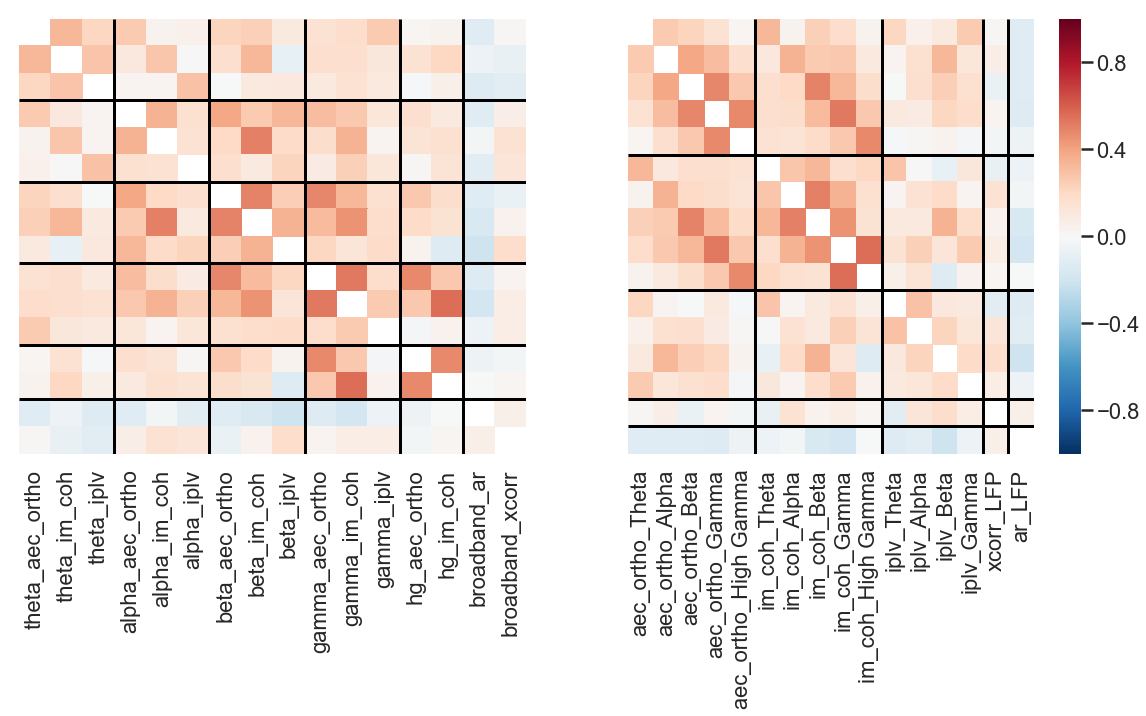

In [586]:
fig, axes = plt.subplots(1,2, figsize=(20,8))
sns.heatmap(band_rsm, xticklabels=True, yticklabels=False, cmap ='RdBu_r',  cbar=False, ax=axes[0],
           vmin=-1, vmax=1)
axes[0].hlines([3,6,9,12,14], xmin=0, xmax=16)
axes[0].vlines([3,6,9,12,14],0,16)
sns.heatmap(meas_rsm, xticklabels=True, yticklabels=False, cmap='RdBu_r', cbar=True, ax=axes[1],
           vmin=-1, vmax=1)
axes[1].hlines([5,10,14,15],0,16)
axes[1].vlines([5,10,14,15],0,16)
plt.savefig(f'../img/band_meas_sim_{yvar}.pdf')

In [587]:
band_within = np.zeros(np.shape(band_rsm))
meas_within = np.zeros(np.shape(band_rsm))
group_within = np.zeros(np.shape(band_rsm))

band_cols = [x.split('_')[0] for x in band_rsm.columns]
meas_cols = [x.split('_')[0] for x in meas_rsm.columns]
band_rows = [x.split('_')[0] for x in band_rsm.index]
meas_rows = [x.split('_')[0] for x in meas_rsm.index]
for b in np.unique(band_rows):
    band_within[np.where([x == b for x in band_rows])[0][0]:(np.where([x == b for x in band_rows])[0][-1] + 1),
                np.where([x == b for x in band_cols])[0][0]:(np.where([x == b for x in band_cols])[0][-1] + 1)] = 1
for m in np.unique(meas_rows):
    meas_within[np.where([x == m for x in meas_rows])[0][0]:(np.where([x == m for x in meas_rows])[0][-1] + 1),
                np.where([x == m for x in meas_cols])[0][0]:(np.where([x == m for x in meas_cols])[0][-1] + 1)] = 1
    
# frequency bands
groups = [['theta','alpha', 'beta'],['gamma','hg']]
for g in groups:
    group_within[np.where([x in g for x in band_rows])[0][0]:(np.where([x in g for x in band_rows])[0][-1] + 1),
                np.where([x in g for x in band_cols])[0][0]:(np.where([x in g for x in band_cols])[0][-1] + 1)] = 1

    

In [588]:
# within band
band_test = band_rsm.as_matrix()
[r,p] = sp.stats.pearsonr(band_within[np.triu_indices(np.size(band_cols),1)],
                 band_test[np.triu_indices(np.size(band_cols),1)])
print([r,p*3])

# get ci
r_z = np.arctanh(r)
se = 1/np.sqrt(np.size(band_test[np.triu_indices(np.size(band_cols),1)]) - 3)
alpha = 0.05
z = sp.stats.norm.ppf(1-alpha/2)
lo, hi = np.tanh(r_z-z*se), np.tanh(r_z+z*se)

y.append(yvar)
rval.append(r)
pval.append(p)
ci_up.append(hi)
ci_lo.append(lo)
label.append('band')

[0.33907164507211335, 0.00045499829884204814]


/Users/stiso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [589]:
# within measure
meas_test = meas_rsm.as_matrix()
[r,p] = sp.stats.pearsonr(meas_within[np.triu_indices(np.size(band_cols),1)],
                 meas_test[np.triu_indices(np.size(band_cols),1)])
print([r,p*3])

# get ci
r_z = np.arctanh(r)
se = 1/np.sqrt(np.size(band_test[np.triu_indices(np.size(band_cols),1)]) - 3)
alpha = 0.05
z = sp.stats.norm.ppf(1-alpha/2)
lo, hi = np.tanh(r_z-z*se), np.tanh(r_z+z*se)

y.append(yvar)
rval.append(r)
pval.append(p)
ci_up.append(hi)
ci_lo.append(lo)
label.append('meas')

[0.4094735000955769, 1.0257199682407067e-05]


/Users/stiso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [590]:
# within tilt group
[r,p] = sp.stats.pearsonr(group_within[np.triu_indices(np.size(band_cols),1)],
                 band_test[np.triu_indices(np.size(band_cols),1)])
print([r,p*3])


# get ci
r_z = np.arctanh(r)
se = 1/np.sqrt(np.size(band_test[np.triu_indices(np.size(band_cols),1)]) - 3)
alpha = 0.05
z = sp.stats.norm.ppf(1-alpha/2)
lo, hi = np.tanh(r_z-z*se), np.tanh(r_z+z*se)

y.append(yvar)
rval.append(r)
pval.append(p)
ci_up.append(hi)
ci_lo.append(lo)
label.append('tilt')

[0.4023609549377281, 1.5672516233800572e-05]


In [597]:
def grouped_barplot(df, cat,subcat, val , err,c,saveas):
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = df[subcat].unique()
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width= np.diff(offsets).mean()
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.bar(x+offsets[i], dfg[val].values, width=width, 
                label="{} {}".format(subcat, gr), yerr=dfg[err].values, color=c[i])
    plt.xlabel(cat)
    plt.ylabel(val)
    plt.xticks(x, u)
    plt.legend()
    plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
    #plt.show()
    plt.savefig(saveas)

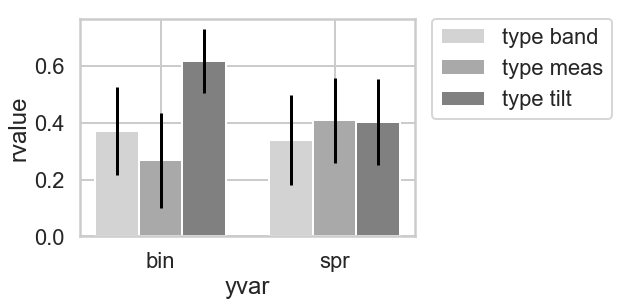

In [598]:
group_sim = pd.DataFrame({'yvar':y,'type':label,'rvalue':rval,'pvalue':pval, 
                          'err':(np.array(ci_up) - np.array(ci_lo))/2})
grouped_barplot(group_sim, 'yvar', 'type', 'rvalue', 'err', 
                ['lightgrey','darkgrey','grey','lightgrey','darkgrey','grey'], f"../img/band_meas_sim2.pdf")


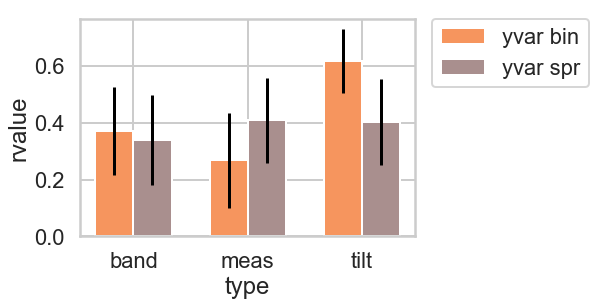

In [599]:
colors = ['#F6955E', '#A98F8E','#F6955E', '#A98F8E','#F6955E', '#A98F8E']
group_sim = pd.DataFrame({'yvar':y,'type':label,'rvalue':rval,'pvalue':pval, 
                          'err':(np.array(ci_up) - np.array(ci_lo))/2})
grouped_barplot(group_sim, 'type', 'yvar', 'rvalue', 'err',colors,f"../img/band_meas_sim.pdf" )


Is it different within or outside of the SOZ?

In [114]:
# add difference for plotting
net_data = net_data.assign(soz_diff_num = net_data['str_soz_beta_num'] - net_data['str_not_soz_beta_num'], 
                           soz_diff_bin = net_data['str_soz_beta_bin'] - net_data['str_not_soz_beta_bin'],
                           soz_diff_spr = net_data['str_soz_beta_spr'] - net_data['str_not_soz_beta_spr'])

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


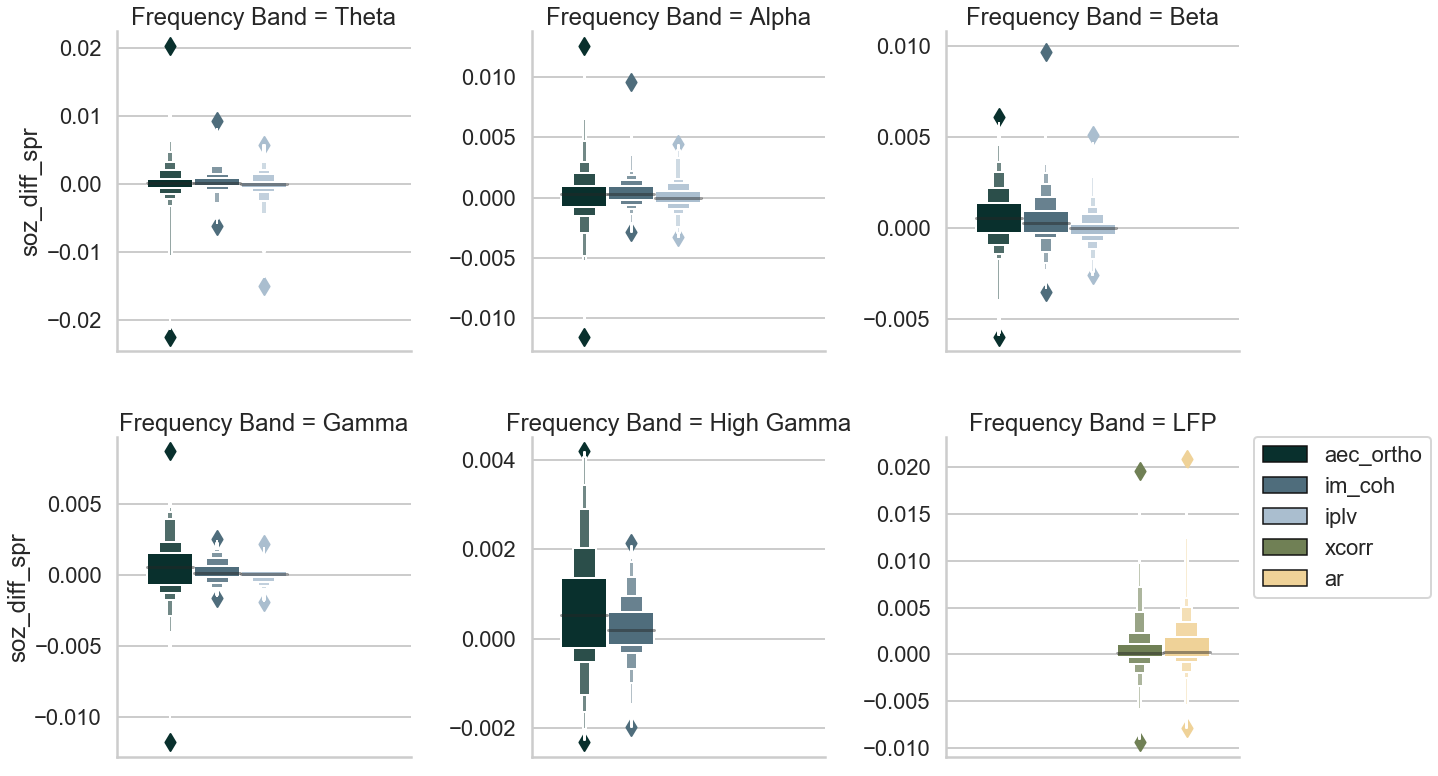

In [128]:
yvar = 'spr'

colors = ['#023732', '#476f84', '#a4bed5', '#72874e', '#fed789']
h_order = ['aec_ortho', 'im_coh', 'iplv', 'xcorr', 'ar']

g = sns.FacetGrid(data=net_data, col='Frequency Band', col_wrap=3, sharex=False, sharey=False, height=6,
                 col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
g.map(sns.boxenplot, "Frequency Band", "soz_diff_" + yvar, "Measure",
             hue_order = h_order,  palette=sns.color_palette(colors))
g.axes[5].legend(bbox_to_anchor=(1.05,1), loc=2,borderaxespad=0.)
for ax in g.axes:
    ax.axes.xaxis.set_visible(False)

g.savefig(f"../img/net_soz_{yvar}{detector}.eps")

In [116]:
# save
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_soz_data_clean{detector}.csv')

Repeat for spikes

In [117]:
# add difference for plotting
net_data = net_data.assign(spike_diff_num = net_data['str_spike_beta_num'] - net_data['str_not_spike_beta_num'], 
                           spike_diff_bin = net_data['str_spike_beta_bin'] - net_data['str_not_spike_beta_bin'],
                          spike_diff_spr = net_data['str_spike_beta_spr'] - net_data['str_not_spike_beta_spr'])

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


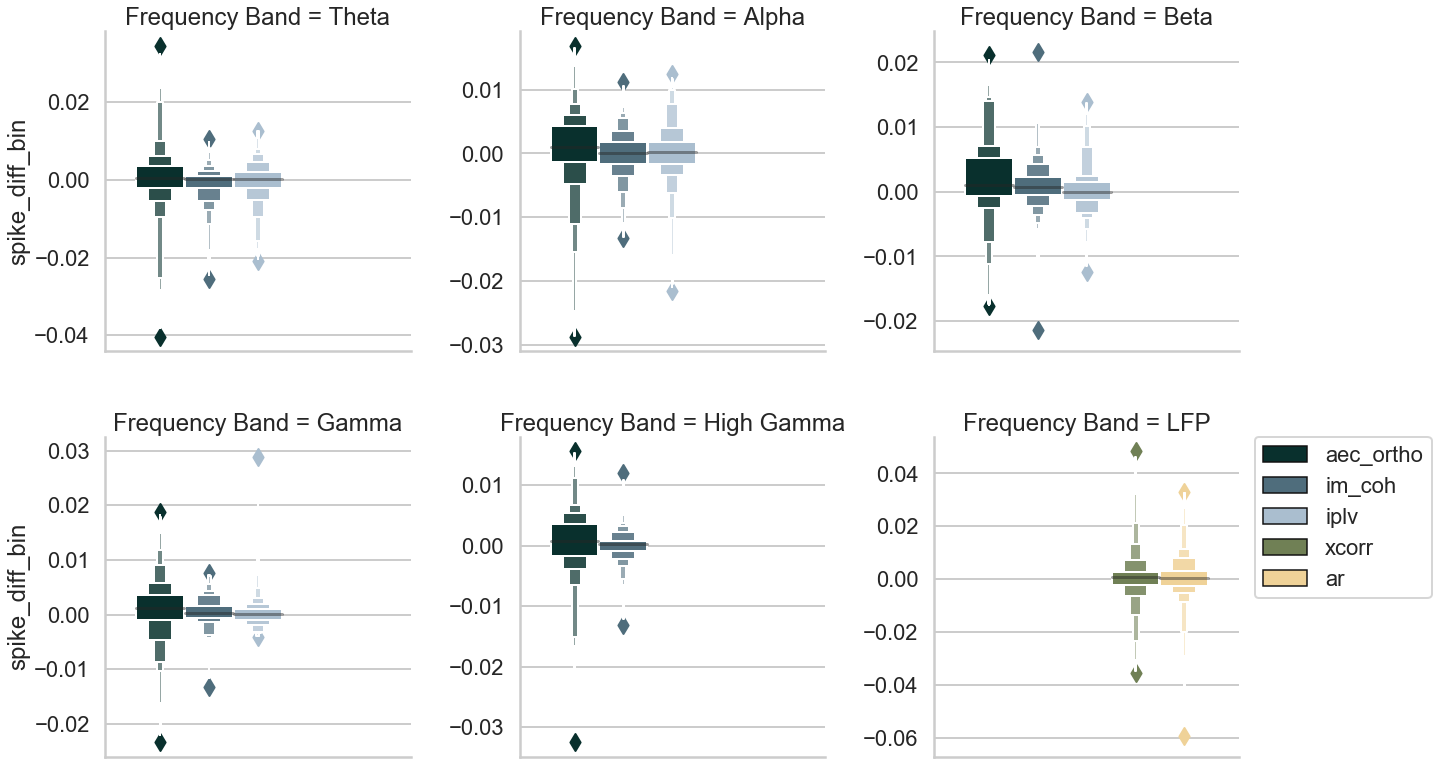

In [131]:
yvar = 'bin'

colors = ['#023732', '#476f84', '#a4bed5', '#72874e', '#fed789']
h_order = ['aec_ortho', 'im_coh', 'iplv', 'xcorr', 'ar']

g=sns.FacetGrid(data=net_data, col="Frequency Band", col_wrap=3, col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'],
                sharex=False, sharey=False, height=6)
g.map(sns.boxenplot, "Frequency Band", "spike_diff_" + yvar, "Measure",
             hue_order = h_order, palette=sns.color_palette(colors))
g.axes[5].legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
for a in g.axes:
    a.axes.xaxis.set_visible(False)
g.savefig(f"../img/net_spike_{yvar}{detector}.eps")

In [119]:
# save
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_spike_data_clean{detector}.csv')

## Which explains more variance? Coverage, or individual?

In [22]:
# remove outliers 3 std for node data
group_mean = node_data.groupby(['band_measure', 'subj']).mean()
group_sd = node_data.groupby(['band_measure', 'subj']).std()*3
bm = group_mean.index
col = group_mean.columns[1:-2]
for b in bm:
    for c in col:
        idx = (node_data['band_measure'] == b[0]) & (node_data['subj'] == b[1]) & ((node_data.loc[:,c] > (group_mean.loc[b,c] + group_sd.loc[b,c])) | 
        node_data.loc[:,c] < (group_mean.loc[b,c] - group_sd.loc[b,c]))
        node_data.loc[idx,c] = np.nan
node_data.head()

elec     band_measure  n_tp  elec_spike  elec_in_soz  str_soz_beta_bin  \
1  L1AG1        alpha_aec   107         0.0          0.0         -0.026133   
2  L1AG1  alpha_aec_ortho   107         0.0          0.0         -0.007675   
3  L1AG1        alpha_coh   107         0.0          0.0         -0.024248   
4  L1AG1     alpha_im_coh   107         0.0          0.0         -0.002853   
5  L1AG1       alpha_iplv   107         0.0          0.0         -0.014903   

   str_not_soz_beta_bin  str_spike_beta_bin  str_not_spike_beta_bin  \
1              0.015728           -0.022966                0.013924   
2              0.015409           -0.016704                0.015192   
3             -0.017144           -0.007096               -0.018538   
4             -0.015401           -0.015273               -0.014043   
5             -0.021155           -0.033347               -0.019412   

   str_beta_bin  ...             region       x        y          z  type  \
1      0.011507  ...   inferiorparietal -40.988 -50.1327  17.177778     D   
2      0.013042  ...   inferiorparietal -40.988 -50.1327  17.177778     D   
3     -0.017818  ...   inferiorparietal -40.988 -50.1327  17.177778     D   
4     -0.014167  ...   inferiorparietal -40.988 -50.1327  17.177778     D   
5     -0.020503  ...   inferiorparietal -40.988 -50.1327  17.177778     D   

     subj  hand   age  gender  race  
1  R1170J     R  20.0       M   2.0  
2  R1170J     R  20.0       M   2.0  
3  R1170J     R  20.0       M   2.0  
4  R1170J     R  20.0       M   2.0  
5  R1170J     R  20.0       M   2.0  

[5 rows x 35 columns]

In [23]:
# get correlation matrix for all str effects
# thi subj has duplicates...unclear why
node_data = node_data[node_data['subj'] != 'R1232N']
sim_data = node_data[['subj', 'region', 'str_beta_bin', 'str_beta_num', 'str_beta_spr', 'band_measure']]
sim_data = sim_data.assign(unique_id = sim_data['subj'] + '_' + sim_data['region'], 
                           reg_id = sim_data['region'] + '_' + sim_data['subj'])
subj_data = sim_data.pivot_table(index = 'unique_id', columns='band_measure', 
                          values = ['str_beta_bin', 'str_beta_num', 'str_beta_spr']) # default agg func is mean
subj_data.head()

str_beta_bin                                         \
band_measure               alpha_aec alpha_aec_ortho alpha_coh alpha_im_coh   
unique_id                                                                     
R1001P_fusiform            -0.002525       -0.002060 -0.000574    -0.000482   
R1001P_inferiortemporal    -0.002935       -0.002855  0.000067    -0.000069   
R1001P_lateraloccipital    -0.002296       -0.001429 -0.000732    -0.001176   
R1001P_lingual             -0.004350       -0.001302 -0.001229    -0.001270   
R1001P_middletemporal      -0.001627       -0.002295 -0.000385    -0.000269   

                                                                       \
band_measure            alpha_iplv alpha_plv  beta_aec beta_aec_ortho   
unique_id                                                               
R1001P_fusiform          -0.000837 -0.000305  0.002808       0.000913   
R1001P_inferiortemporal  -0.000599 -0.000344 -0.000039      -0.000018   
R1001P_lateraloccipital  -0.003465 -0.002843  0.001363       0.001536   
R1001P_lingual           -0.000434 -0.000792  0.000378       0.000531   
R1001P_middletemporal    -0.002245 -0.000704 -0.000239      -0.002384   

                                                 ...    str_beta_spr  \
band_measure             beta_coh beta_im_coh    ...          hg_aec   
unique_id                                        ...                   
R1001P_fusiform          0.000739    0.000190    ...        0.000404   
R1001P_inferiortemporal -0.001398   -0.001075    ...        0.000300   
R1001P_lateraloccipital -0.000974   -0.001035    ...       -0.000022   
R1001P_lingual          -0.002363   -0.001691    ...        0.000729   
R1001P_middletemporal    0.001682    0.001234    ...        0.000952   

                                                                    \
band_measure            hg_aec_ortho    hg_coh hg_im_coh theta_aec   
unique_id                                                            
R1001P_fusiform             0.000144  0.000266  0.000062 -0.000178   
R1001P_inferiortemporal    -0.000029  0.000106 -0.000077  0.001601   
R1001P_lateraloccipital    -0.000067 -0.000108 -0.000058 -0.001511   
R1001P_lingual              0.000819  0.000809  0.000652  0.001859   
R1001P_middletemporal       0.000706  0.000954  0.000569  0.001692   

                                                                           \
band_measure            theta_aec_ortho theta_coh theta_im_coh theta_iplv   
unique_id                                                                   
R1001P_fusiform               -0.000263  0.001439     0.000726  -0.000634   
R1001P_inferiortemporal        0.000141  0.001221     0.000565  -0.000358   
R1001P_lateraloccipital       -0.001176  0.000753     0.000497  -0.000876   
R1001P_lingual                 0.001409  0.002080     0.001349  -0.000224   
R1001P_middletemporal          0.001930  0.000978     0.000571  -0.000408   

                                   
band_measure            theta_plv  
unique_id                          
R1001P_fusiform          0.000041  
R1001P_inferiortemporal -0.000741  
R1001P_lateraloccipital -0.000072  
R1001P_lingual           0.000438  
R1001P_middletemporal   -0.000689  

[5 rows x 90 columns]

In [24]:
# get correlation matrix for all str effects
reg_data = sim_data.pivot_table(index = 'reg_id', columns='band_measure', 
                          values = ['str_beta_bin', 'str_beta_num', 'str_beta_spr']) # default agg func is mean
reg_data.head()

str_beta_bin                                         \
band_measure       alpha_aec alpha_aec_ortho alpha_coh alpha_im_coh   
reg_id                                                                
bankssts_R1008J     0.004012        0.000718  0.006418     0.004330   
bankssts_R1009W     0.006340        0.000975  0.001528     0.001677   
bankssts_R1014D    -0.005559        0.006178 -0.024950    -0.011233   
bankssts_R1019J    -0.000193        0.000991  0.000842     0.000462   
bankssts_R1022J     0.002767        0.001633  0.000283     0.000408   

                                                                         \
band_measure    alpha_iplv alpha_plv  beta_aec beta_aec_ortho  beta_coh   
reg_id                                                                    
bankssts_R1008J   0.004610  0.004590 -0.000383       0.000522  0.001345   
bankssts_R1009W   0.011697  0.011880 -0.007243      -0.008472 -0.000783   
bankssts_R1014D   0.000913 -0.006086  0.012066       0.021330 -0.010065   
bankssts_R1019J   0.000686  0.001496  0.000228      -0.000044  0.000497   
bankssts_R1022J   0.000916  0.001790 -0.001169      -0.000479  0.001686   

                               ...    str_beta_spr                         \
band_measure    beta_im_coh    ...          hg_aec hg_aec_ortho    hg_coh   
reg_id                         ...                                          
bankssts_R1008J    0.001276    ...        0.000215     0.000057  0.000027   
bankssts_R1009W    0.001972    ...        0.001034     0.000239  0.000256   
bankssts_R1014D   -0.002758    ...        0.009262     0.003567 -0.011489   
bankssts_R1019J    0.000381    ...        0.000003    -0.000039 -0.000034   
bankssts_R1022J    0.001283    ...        0.000228     0.000162  0.000209   

                                                                            \
band_measure    hg_im_coh theta_aec theta_aec_ortho theta_coh theta_im_coh   
reg_id                                                                       
bankssts_R1008J  0.000120 -0.000899       -0.000734  0.000863     0.000319   
bankssts_R1009W -0.000371  0.015627        0.006705  0.006046     0.003866   
bankssts_R1014D -0.002100  0.004694        0.003606 -0.008951    -0.007249   
bankssts_R1019J -0.000047 -0.000013        0.000130 -0.000028    -0.000021   
bankssts_R1022J  0.000113 -0.000414        0.000271  0.000211     0.000241   

                                      
band_measure    theta_iplv theta_plv  
reg_id                                
bankssts_R1008J  -0.000296 -0.001121  
bankssts_R1009W  -0.000053 -0.003243  
bankssts_R1014D  -0.002792 -0.006690  
bankssts_R1019J  -0.000097 -0.000121  
bankssts_R1022J  -0.000611 -0.000593  

[5 rows x 90 columns]

In [25]:
# ordered by subj corr map
sim_metric = 'corr' # correlation or euclidean distance
if sim_metric == 'corr':
    rsm = subj_data.T.corr(method="spearman")
    reg_rsm = reg_data.T.corr(method="spearman")
else:
    rsm = euclidean_distances(subj_data)
    reg_rsm = euclidean_distances(reg_data)

In [26]:
np.shape(rsm)

(2246, 2246)

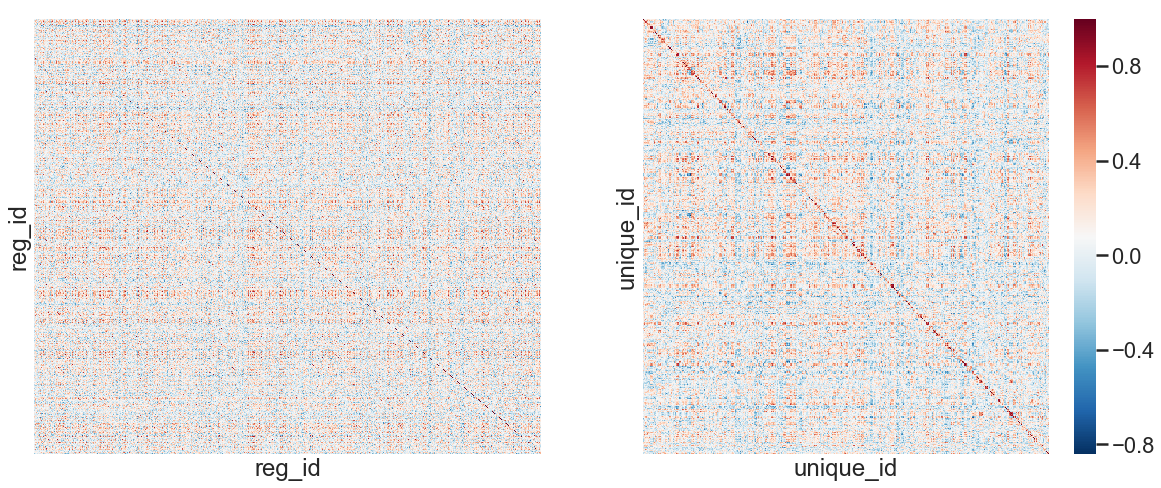

In [396]:
fig, axes = plt.subplots(1,2, figsize=(20,8))
sns.heatmap(reg_rsm, xticklabels=False, yticklabels=False, cmap = 'RdBu_r',  cbar=False, ax=axes[0])
sns.heatmap(rsm, xticklabels=False, yticklabels=False, cmap='RdBu_r', cbar=True, ax=axes[1])
plt.savefig('../img/subj_sim.png')

In [398]:
subj_within = np.zeros(np.shape(rsm))
reg_within = np.zeros(np.shape(rsm))

reg_cols = [x.split('_')[0] for x in reg_rsm.columns]
subj_cols = [x.split('_')[0] for x in rsm.columns]
reg_rows = [x.split('_')[0] for x in reg_rsm.index]
subj_rows = [x.split('_')[0] for x in rsm.index]
for s in np.unique(subj_rows):
    subj_within[np.where([x == s for x in subj_rows])[0][0]:(np.where([x == s for x in subj_rows])[0][-1] + 1),
                np.where([x == s for x in subj_cols])[0][0]:(np.where([x == s for x in subj_cols])[0][-1] + 1)] = 1
for r in np.unique(reg_rows):
    reg_within[np.where([x == r for x in reg_rows])[0][0]:(np.where([x == r for x in reg_rows])[0][-1] + 1),
                np.where([x == r for x in reg_cols])[0][0]:(np.where([x == r for x in reg_cols])[0][-1] + 1)] = 1

    

In [570]:
# within subj
rval = []
pval = []
label = []
ci_lo = []
ci_hi = []

subj_test = rsm.as_matrix()
x = subj_within[np.triu_indices(np.size(subj_cols),1)]
y = subj_test[np.triu_indices(np.size(subj_cols),1)]
x = x[[not i for i in np.isnan(y)]]
y = y[[not i for i in np.isnan(y)]]
[r,p] = sp.stats.pearsonr(x,y)
print([r,p*2])

r_z = np.arctanh(r)
se = 1/np.sqrt(np.size(x) - 3)
alpha = 0.05
z = sp.stats.norm.ppf(1-alpha/2)
lo, hi = np.tanh(r_z-z*se), np.tanh(r_z+z*se)

ci_hi.append(hi)
ci_lo.append(lo)
rval.append(r)
pval.append(p)
label.append('subj')

/Users/stiso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


[0.14281694454452995, 0.0]


In [571]:
# within reg
reg_test = reg_rsm.as_matrix()
x = reg_within[np.triu_indices(np.size(reg_cols),1)]
y = reg_test[np.triu_indices(np.size(reg_cols),1)]
x = x[[not i for i in np.isnan(y)]]
y = y[[not i for i in np.isnan(y)]]
[r,p] = sp.stats.pearsonr(x,y)
print([r,p*2]) #adding MC correction

r_z = np.arctanh(r)
se = 1/np.sqrt(np.size(x) - 3)
alpha = 0.05
z = sp.stats.norm.ppf(1-alpha/2)
lo, hi = np.tanh(r_z-z*se), np.tanh(r_z+z*se)

ci_lo.append(lo)
ci_hi.append(hi)
rval.append(r)
pval.append(p)
label.append('reg')

/Users/stiso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


[0.0013450944902943882, 0.0654005071348957]


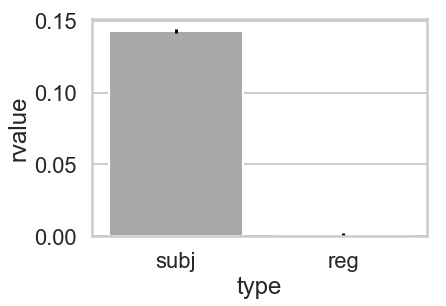

In [573]:
group_sim = pd.DataFrame({'type':label,'rvalue':(rval),'pvalue':pval, 
                          'ci':((np.array(ci_hi) - np.array(ci_lo))/2)})
sns.barplot(data=group_sim,x='type',y='rvalue',yerr=group_sim['ci'], color='darkgrey')
plt.savefig(f"../img/subj_reg_sim.pdf")

In [415]:
np.size(x)

2521117

## Effects on Node Measures

relationship between the number of spikes seen in that node, and the beta value

/Users/stiso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


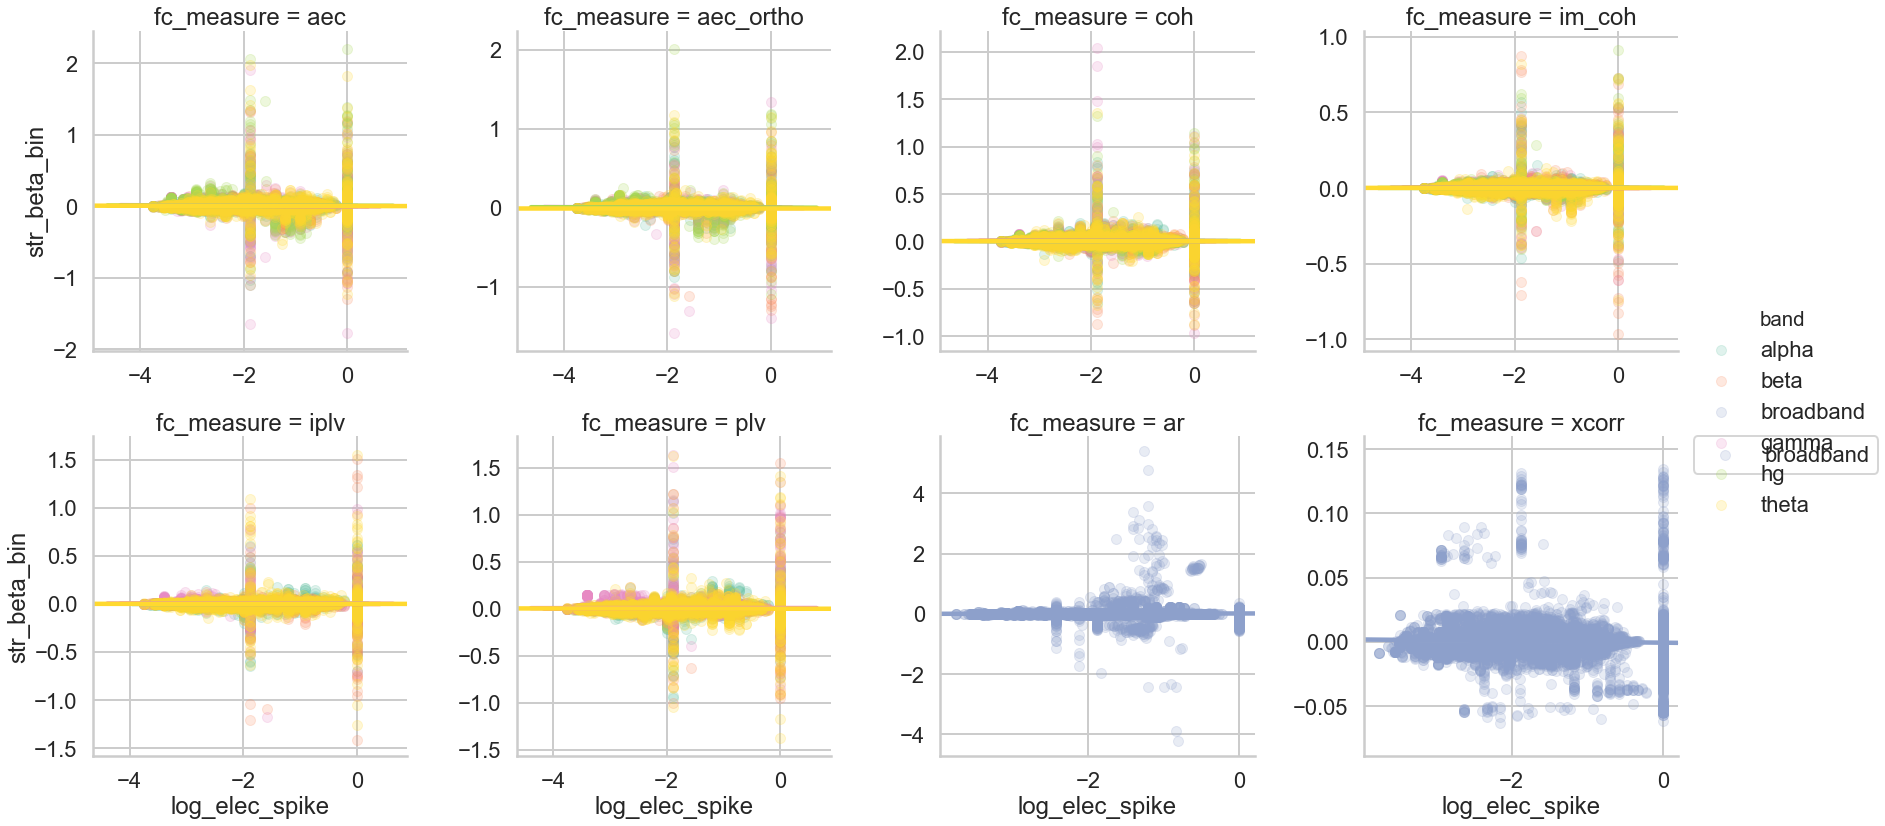

In [604]:
# add log transform
log_spike = np.zeros(np.shape(node_data['elec_spike']))
log_spike[[node_data['elec_spike'] != 0]] = np.log10(node_data['elec_spike'][node_data['elec_spike'] != 0])
node_data['log_elec_spike'] = log_spike

#color pallette
colors = ['#5b6c88', '#f0eee2']
custom_palette = sns.set_palette('Set2')

#plt.figure(figsize=(40,20))
sns.lmplot(data=node_data, x='log_elec_spike', y='str_beta_bin', hue='band', col="fc_measure", 
           col_wrap=4, height=6, sharex=False, sharey=False, scatter_kws={'s':100, 'alpha':.2})

plt.legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
#for ax in g.axes:
#    ax.set_ylim(-2,2)
    

Total strength by type

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


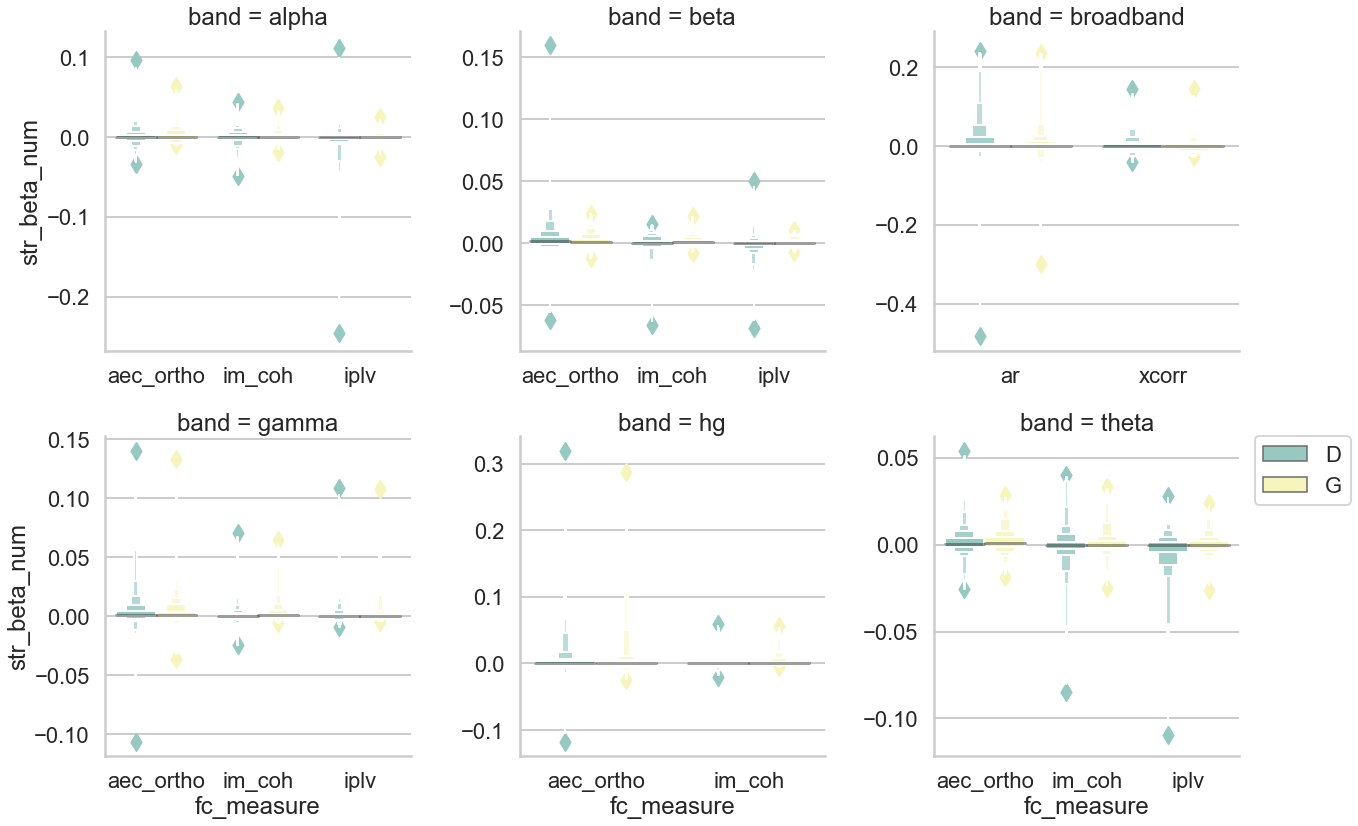

In [605]:
# strip is functionally the same as grid
node_data.loc[node_data.type == 'S','type'] = 'G'
type_avg = node_data.groupby(['subj', 'band', 'fc_measure', 'type']).median().reset_index()
type_avg = type_avg[(type_avg['fc_measure'] != 'aec') & (type_avg['fc_measure'] != 'coh') & (type_avg['fc_measure'] != 'plv')]
# grand teton natl park color pallette
colors = ['#a8d0cf', '#babbb1']
custom_palette = sns.set_palette(sns.color_palette(colors))
    
g = sns.FacetGrid(data=type_avg, col='band', col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, size=6)
g.map(sns.boxenplot, 'fc_measure', 'str_beta_num', 'type', palette = 'Set3', hue_order = ['D','G'])

g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
type_avg.to_csv(f'{RAM_dir}group_analysis/win_{win}/type_stats{detector}.csv')

## Check for differences based on coverage

M    65
D    64
G    14
Name: contacts, dtype: int64

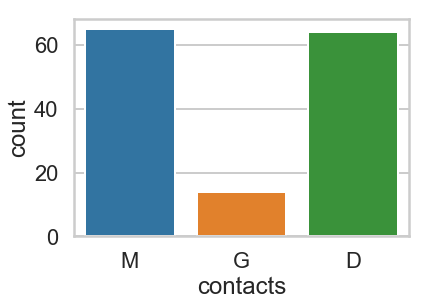

In [25]:
# check for strip grid difference
elec_type = node_data.groupby('subj').type.unique().reset_index()
def label_row(row):
    if ('G' in row['type']) & ('D' in row['type']):
        return 'M'
    elif all(('G' == row['type']) | ('S' == row['type'])):
        return 'G'
    elif all('D' == row['type']):
        return 'D'
    else:
        return 'M'
elec_type['contacts'] = elec_type.apply(lambda x: label_row(x), axis=1)
sns.countplot(elec_type.contacts)
elec_type.contacts.value_counts()

In [26]:
# merge
#net_data.drop('contacts', axis=1, inplace=True)
net_data = pd.merge(net_data, elec_type, on = 'subj')

In [27]:
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4350 entries, 0 to 4349
Data columns (total 29 columns):
band_measure              4350 non-null object
n_tp                      4350 non-null int64
str_beta_bin              4248 non-null float64
str_beta_num              4260 non-null float64
str_beta_spr              4248 non-null float64
ti_beta_bin               4253 non-null float64
ti_beta_num               4257 non-null float64
ti_beta_spr               4264 non-null float64
str_soz_beta_bin          3042 non-null float64
str_soz_beta_num          3086 non-null float64
str_soz_beta_spr          3089 non-null float64
str_not_soz_beta_num      3074 non-null float64
str_spike_beta_num        2967 non-null float64
str_not_soz_beta_spr      3070 non-null float64
str_not_soz_beta_bin      3026 non-null float64
str_spike_beta_bin        2926 non-null float64
str_spike_beta_spr        2969 non-null float64
str_not_spike_beta_bin    2909 non-null float64
Measure                   4350 n

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


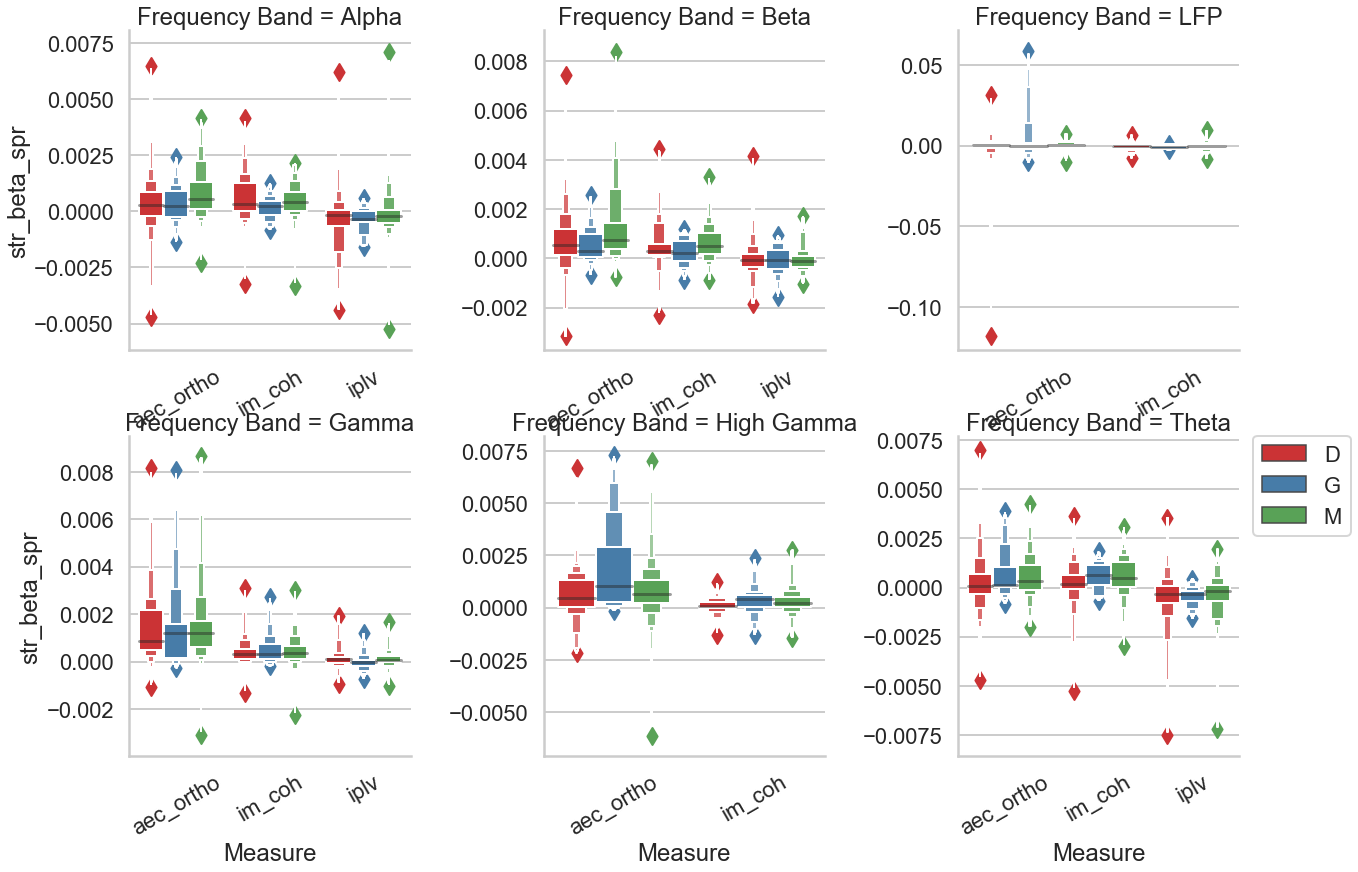

In [31]:
yvar = 'spr'
g = sns.FacetGrid(data=net_data[(net_data['Measure'] != 'aec') & (net_data['Measure'] != 'coh') & (net_data['Measure'] != 'plv')], col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=6, )
g.map(sns.boxenplot, 'Measure', 'str_beta_' + yvar, 'contacts', palette = 'Set1', 
      hue_order=['D','G', 'M'])
for a in g.axes:
    a.set_xticklabels(g.axes[0].xaxis.get_majorticklabels(),rotation=30)

g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
g.savefig(f"../img/contacts_{yvar}.pdf")

In [610]:
net_data.subj.nunique()

143

## Variance by system

In [611]:
# load system data
sys = pd.read_csv(f'{RAM_dir}group_analysis/win_{win}/contact_sys.csv', index_col=0)


In [612]:
# check number of contacts
# contacts that are really far away end up labelled as vis
sys['sys'].value_counts()

Vis            97140
Default         4647
Limbic          2391
SalVentAttn     1940
SomMot          1597
Cont            1416
DorsAttn        1320
Name: sys, dtype: int64

In [613]:
sys.groupby(['subj','sys']).min_d.mean().head(25)

subj    sys        
R1001P  Cont            13.462925
        Default         16.000491
        DorsAttn        12.306150
        Limbic          20.120398
        SalVentAttn     15.065420
        SomMot          13.164589
        Vis             14.353137
R1002P  Cont            14.499693
        Default         20.114818
        DorsAttn        16.196721
        Limbic          19.731470
        SalVentAttn     19.326486
        SomMot          13.525720
        Vis             16.885360
R1003P  Vis                   NaN
R1004D  Cont           120.370063
        Default        153.841812
        SalVentAttn    128.240812
R1006P  Vis                   NaN
R1008J  Default         15.089609
        DorsAttn        16.060019
        Limbic          16.926507
        SalVentAttn     16.998840
        Vis             15.265479
R1009W  Vis                   NaN
Name: min_d, dtype: float64

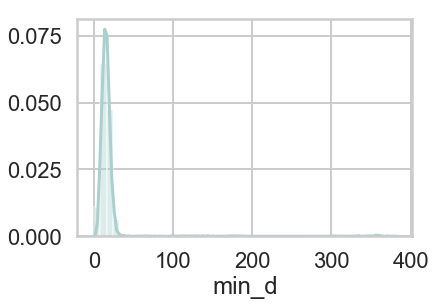

In [614]:
# how well are the MNI coordinates doing? Are centroids usually close?
sns.distplot(sys['min_d'].dropna())

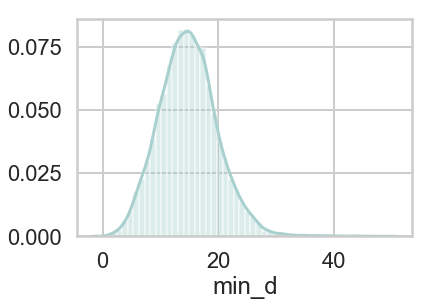

In [615]:
# get reid of contacts that clearly had poor match - greater than 2 std
sys.loc[sys['min_d'] > sys['min_d'].mean() + sys['min_d'].std(),['sys', 'parc', 'min_d', 'region']] = np.nan
sns.distplot(sys['min_d'].dropna())

In [616]:
# merge
node_data = pd.merge(node_data, sys, on=['subj', 'elec', 'region', 'x' ,'y', 'z', 'race', 
                                         'hand', 'gender', 'type', 'age'])
node_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2132130 entries, 0 to 2132129
Data columns (total 40 columns):
elec                      object
band_measure              object
n_tp                      int64
elec_spike                float64
elec_in_soz               int64
str_soz_beta_bin          float64
str_not_soz_beta_bin      float64
str_spike_beta_bin        float64
str_not_spike_beta_bin    float64
str_beta_bin              float64
str_soz_beta_num          float64
str_not_soz_beta_num      float64
str_spike_beta_num        float64
str_beta_num              float64
str_not_spike_beta_num    float64
ti_beta_bin               float64
ti_beta_num               float64
ti_beta_spr               float64
str_beta_spr              float64
str_soz_beta_spr          float64
str_not_soz_beta_spr      float64
str_spike_beta_spr        float64
str_not_spike_beta_spr    float64
fc_measure                object
band                      object
region                    object
x           

In [617]:
# get region -> system mapping to see if the MNI labels are any good
node_data.dropna(inplace=True, axis=0, subset=['min_d'])
reg_sys_map = node_data.groupby(['subj', 'elec'])[['region','sys']].head()
reg_sys_map.to_csv(f'{RAM_dir}group_analysis/win_{win}/reg_sys_map{detector}.csv')
reg_sys_map.head()


region      sys
0  inferiorparietal  Default
1  inferiorparietal  Default
2  inferiorparietal  Default
3  inferiorparietal  Default
4  inferiorparietal  Default

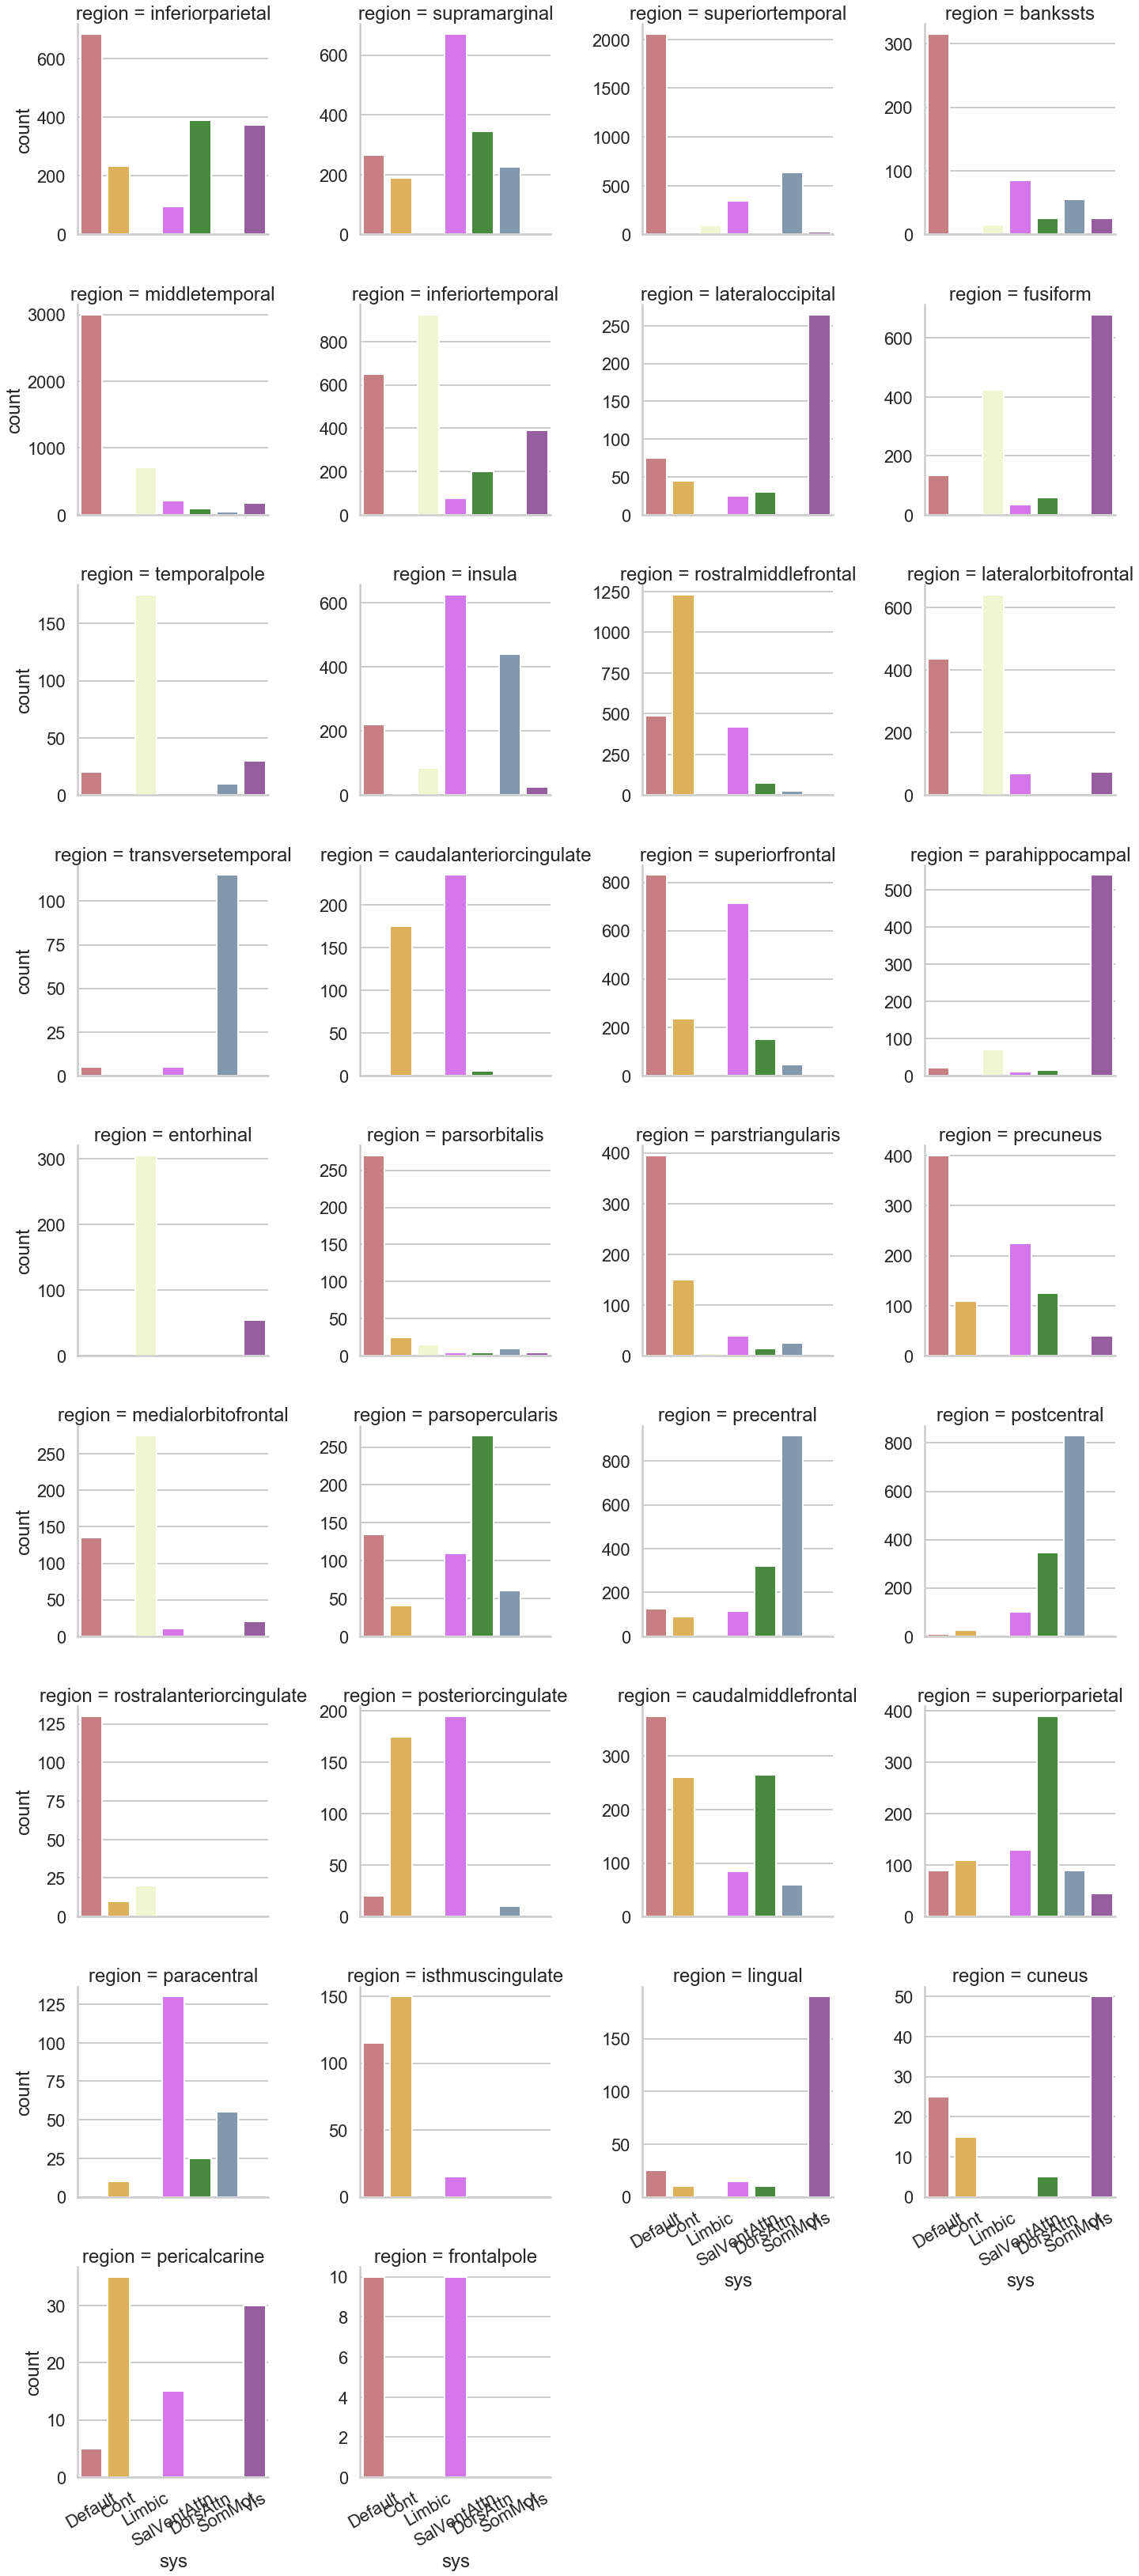

In [618]:
sys_colors = ['#d37379', '#f3b743', '#f5fccc', '#e164fe', '#3e9730', '#7b98b3', '#9f53aa']
sys_pal = sns.color_palette(sys_colors)
p = sns.catplot(data=reg_sys_map, x='sys', col='region', kind='count', col_wrap=4, sharey=False,
           order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'],
           palette=sys_pal)
for a in p.axes:
    a.set_xticklabels(a.xaxis.get_majorticklabels(), rotation=30)
p.savefig(f'{RAM_dir}img/MNI_labels.png')

In [619]:
# z-score within subject node_data.drop(['scale_num', 'scale_bin'], axis=1, inplace=True) # comment this out if defining scaled vars for the first time
node_data.insert(5, 'scale_num', node_data.groupby(['subj', 'band_measure'])['str_beta_num'].transform(
    lambda x: sp.stats.zscore(x)))
node_data.insert(5, 'scale_bin', node_data.groupby(['subj', 'band_measure'])['str_beta_bin'].transform(
    lambda x: sp.stats.zscore(x)))
node_data.insert(5, 'scale_spr', node_data.groupby(['subj', 'band_measure'])['str_beta_spr'].transform(
    lambda x: sp.stats.zscore(x)))
# average over systems, so every subj has 1 pt per sys (if they had coverage there)
sys_avg = node_data.groupby(['subj', 'band', 'fc_measure', 'sys'])['scale_bin', 'scale_num', 'scale_spr'].median().reset_index()
sys_avg.head()
sys_avg.to_csv(f'{RAM_dir}group_analysis/win_{win}/sys_stats.csv')

/Users/stiso/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2315: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


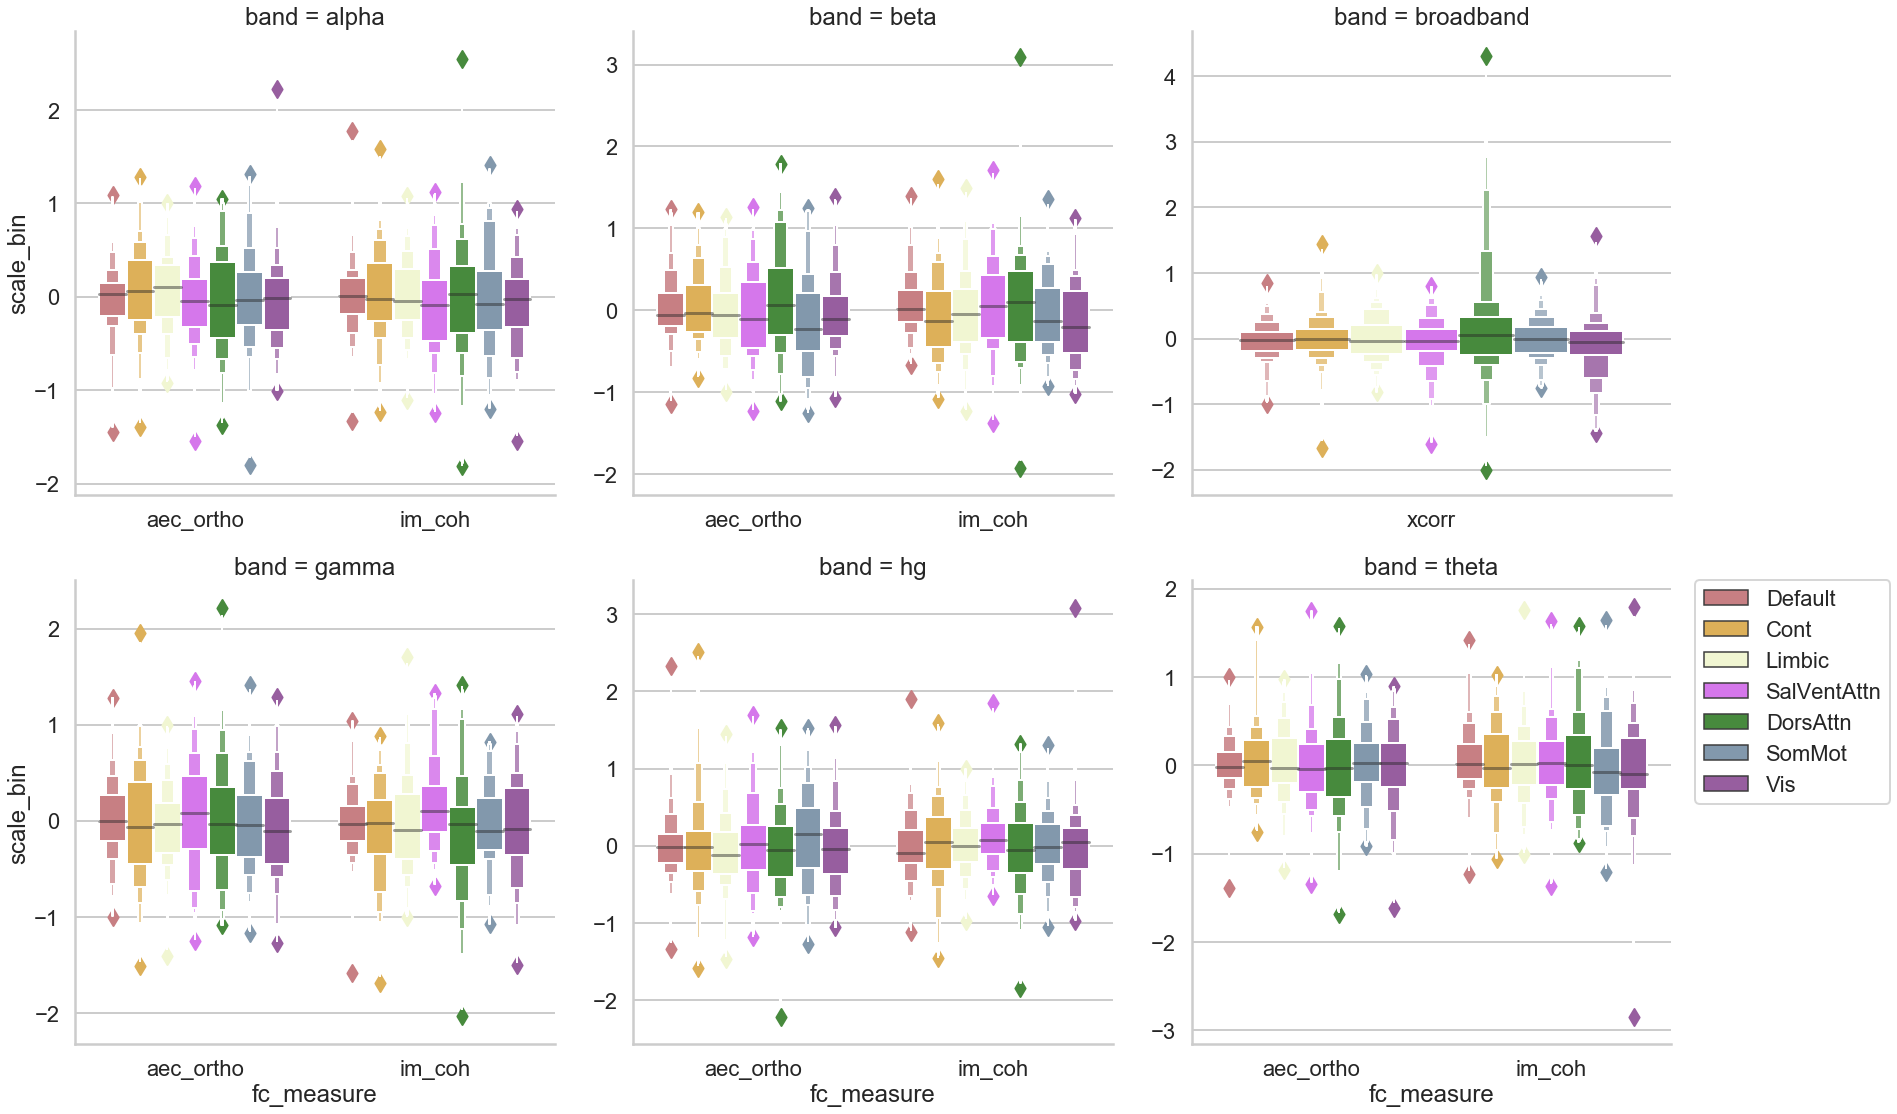

In [620]:
sys_avg = sys_avg[(sys_avg['fc_measure'] != 'aec') & (sys_avg['fc_measure'] != 'plv') & (sys_avg['fc_measure'] != 'coh')
                 & (sys_avg['fc_measure'] != 'iplv') & (sys_avg['fc_measure'] != 'ar')]
g = sns.FacetGrid(data=sys_avg, col='band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8)
g.map(sns.boxenplot, 'fc_measure', 'scale_bin', 'sys', palette = sys_pal,
     hue_order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'])
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
#for ax in g.axes:
#    ax.set_ylim(-2,2)
    
g.savefig("../img/reg_sys.pdf")

## Clinical Data

In [621]:
clinical = pd.read_csv(f'{RAM_dir}RAM_Stiso.csv')

In [622]:
clinical.head()

Subject Lesional Institution   Age Sex       Race     Ethnicity  \
0        1      NaN        Penn  50.0   F      Black  Non-Hispanic   
1        2      NaN        Penn  51.0   F  Caucasian  Non-Hispanic   
2        3      NaN        Penn  41.0   F  Caucasian  Non-Hispanic   
3        4      NaN   Dartmouth  54.0   F  Caucasian  Non-Hispanic   
4        5      NaN        Penn  22.0   F  Caucasian  Non-Hispanic   

     Handedness  Education  SeizureAge Etiology  
0         Right       13.0        20.0  Unknown  
1         Right       16.0        34.0  Unknown  
2  Ambidextrous       13.0        37.0  Unknown  
3         Right       12.0         6.0    Other  
4           NaN        NaN         NaN      NaN

In [623]:
clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 11 columns):
Subject        408 non-null int64
Lesional       40 non-null object
Institution    408 non-null object
Age            388 non-null float64
Sex            392 non-null object
Race           372 non-null object
Ethnicity      368 non-null object
Handedness     372 non-null object
Education      296 non-null float64
SeizureAge     366 non-null float64
Etiology       339 non-null object
dtypes: float64(3), int64(1), object(7)
memory usage: 35.1+ KB


In [624]:
clinical.describe()

Subject         Age   Education  SeizureAge
count  408.000000  388.000000  296.000000  366.000000
mean   204.500000   36.579897   13.866554   18.198361
std    117.923704   11.538333    2.662342   12.973057
min      1.000000   17.000000    3.000000    0.000000
25%    102.750000   26.750000   12.000000    8.000000
50%    204.500000   36.000000   14.000000   16.000000
75%    306.250000   46.000000   16.000000   26.000000
max    408.000000   66.000000   24.000000   59.000000

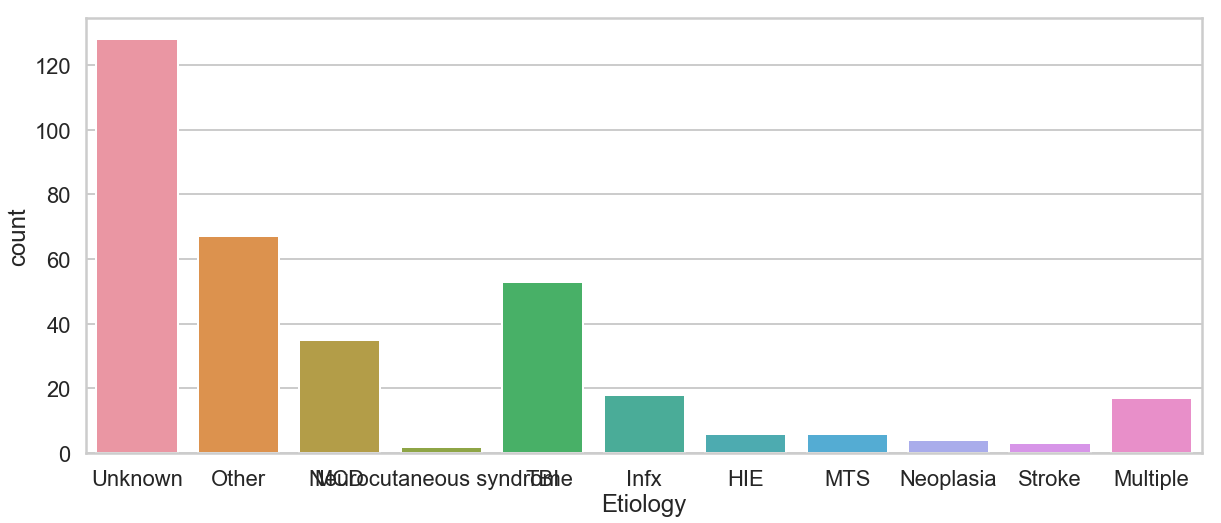

In [625]:
fig = plt.figure(figsize=(20,8))
sns.countplot(data=clinical, x='Etiology')

In [626]:
clinical['Etiology'].value_counts()

Unknown                    128
Other                       67
TBI                         53
MCD                         35
Infx                        18
Multiple                    17
HIE                          6
MTS                          6
Neoplasia                    4
Stroke                       3
Neurocutaneous syndrome      2
Name: Etiology, dtype: int64

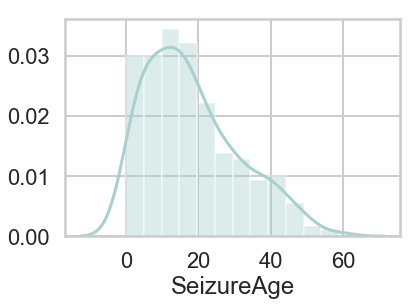

In [627]:
sns.distplot(clinical['SeizureAge'].dropna())

In [628]:
# get subject to the same naming convention
clinical['subj'] = clinical.apply(lambda x: 'R1' + '{0:0=3d}'.format(x['Subject']) + x['Institution'][0], axis=1)
clinical.drop(['Subject', 'Age', 'Sex', 'Race', 'Handedness'], axis=1, inplace=True)
clinical.head()

Lesional Institution     Ethnicity  Education  SeizureAge Etiology    subj
0      NaN        Penn  Non-Hispanic       13.0        20.0  Unknown  R1001P
1      NaN        Penn  Non-Hispanic       16.0        34.0  Unknown  R1002P
2      NaN        Penn  Non-Hispanic       13.0        37.0  Unknown  R1003P
3      NaN   Dartmouth  Non-Hispanic       12.0         6.0    Other  R1004D
4      NaN        Penn  Non-Hispanic        NaN         NaN      NaN  R1005P

In [629]:
# add 'nonlesional' category
clinical.loc[clinical['Lesional'].isna(),'Lesional'] = 'Nonlesional'
clinical.head()

Lesional Institution     Ethnicity  Education  SeizureAge Etiology  \
0  Nonlesional        Penn  Non-Hispanic       13.0        20.0  Unknown   
1  Nonlesional        Penn  Non-Hispanic       16.0        34.0  Unknown   
2  Nonlesional        Penn  Non-Hispanic       13.0        37.0  Unknown   
3  Nonlesional   Dartmouth  Non-Hispanic       12.0         6.0    Other   
4  Nonlesional        Penn  Non-Hispanic        NaN         NaN      NaN   

     subj  
0  R1001P  
1  R1002P  
2  R1003P  
3  R1004D  
4  R1005P

In [630]:
# merge with net data
subj_idx = [x in net_data.subj.unique() for x in clinical.subj]
net_data = pd.merge(net_data,clinical[subj_idx], on='subj', how='outer')
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2320 entries, 0 to 2319
Data columns (total 36 columns):
band_measure              2320 non-null object
n_tp                      2320 non-null int64
str_beta_bin              2268 non-null float64
str_beta_num              2278 non-null float64
str_beta_spr              2267 non-null float64
ti_beta_bin               2268 non-null float64
ti_beta_num               2273 non-null float64
ti_beta_spr               2272 non-null float64
str_soz_beta_bin          1621 non-null float64
str_soz_beta_num          1645 non-null float64
str_soz_beta_spr          1645 non-null float64
str_not_soz_beta_num      1638 non-null float64
str_spike_beta_num        1583 non-null float64
str_not_soz_beta_spr      1632 non-null float64
str_not_soz_beta_bin      1610 non-null float64
str_spike_beta_bin        1565 non-null float64
str_spike_beta_spr        1585 non-null float64
str_not_spike_beta_bin    1549 non-null float64
Measure                   2320 n

In [631]:
net_data.subj.nunique()

143

In [632]:
# save
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/clinical{detector}.csv')

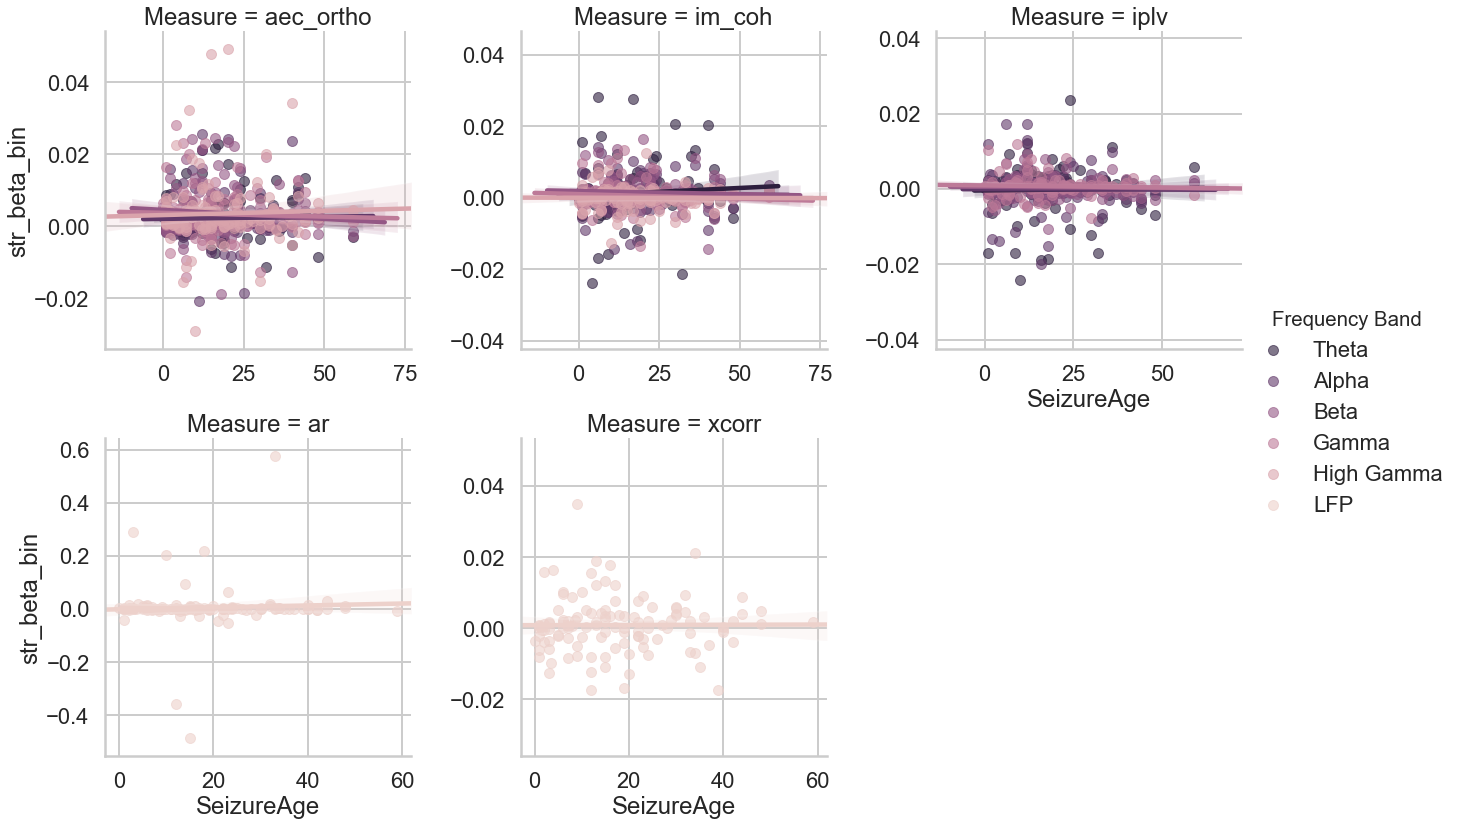

In [633]:
yvar='bin'
sns.lmplot(data=net_data, x='SeizureAge', y='str_beta_' + yvar, hue='Frequency Band', col="Measure", 
           col_wrap=3, height=6, sharex=False, sharey=False, 
           palette=sns.color_palette(sns.cubehelix_palette(6, reverse=True)), 
           scatter_kws={'s':100, 'alpha':.6}, 
           hue_order=['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
plt.savefig(f"../img/seizure_onset_{yvar}_{detector}.png")

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the boxenplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


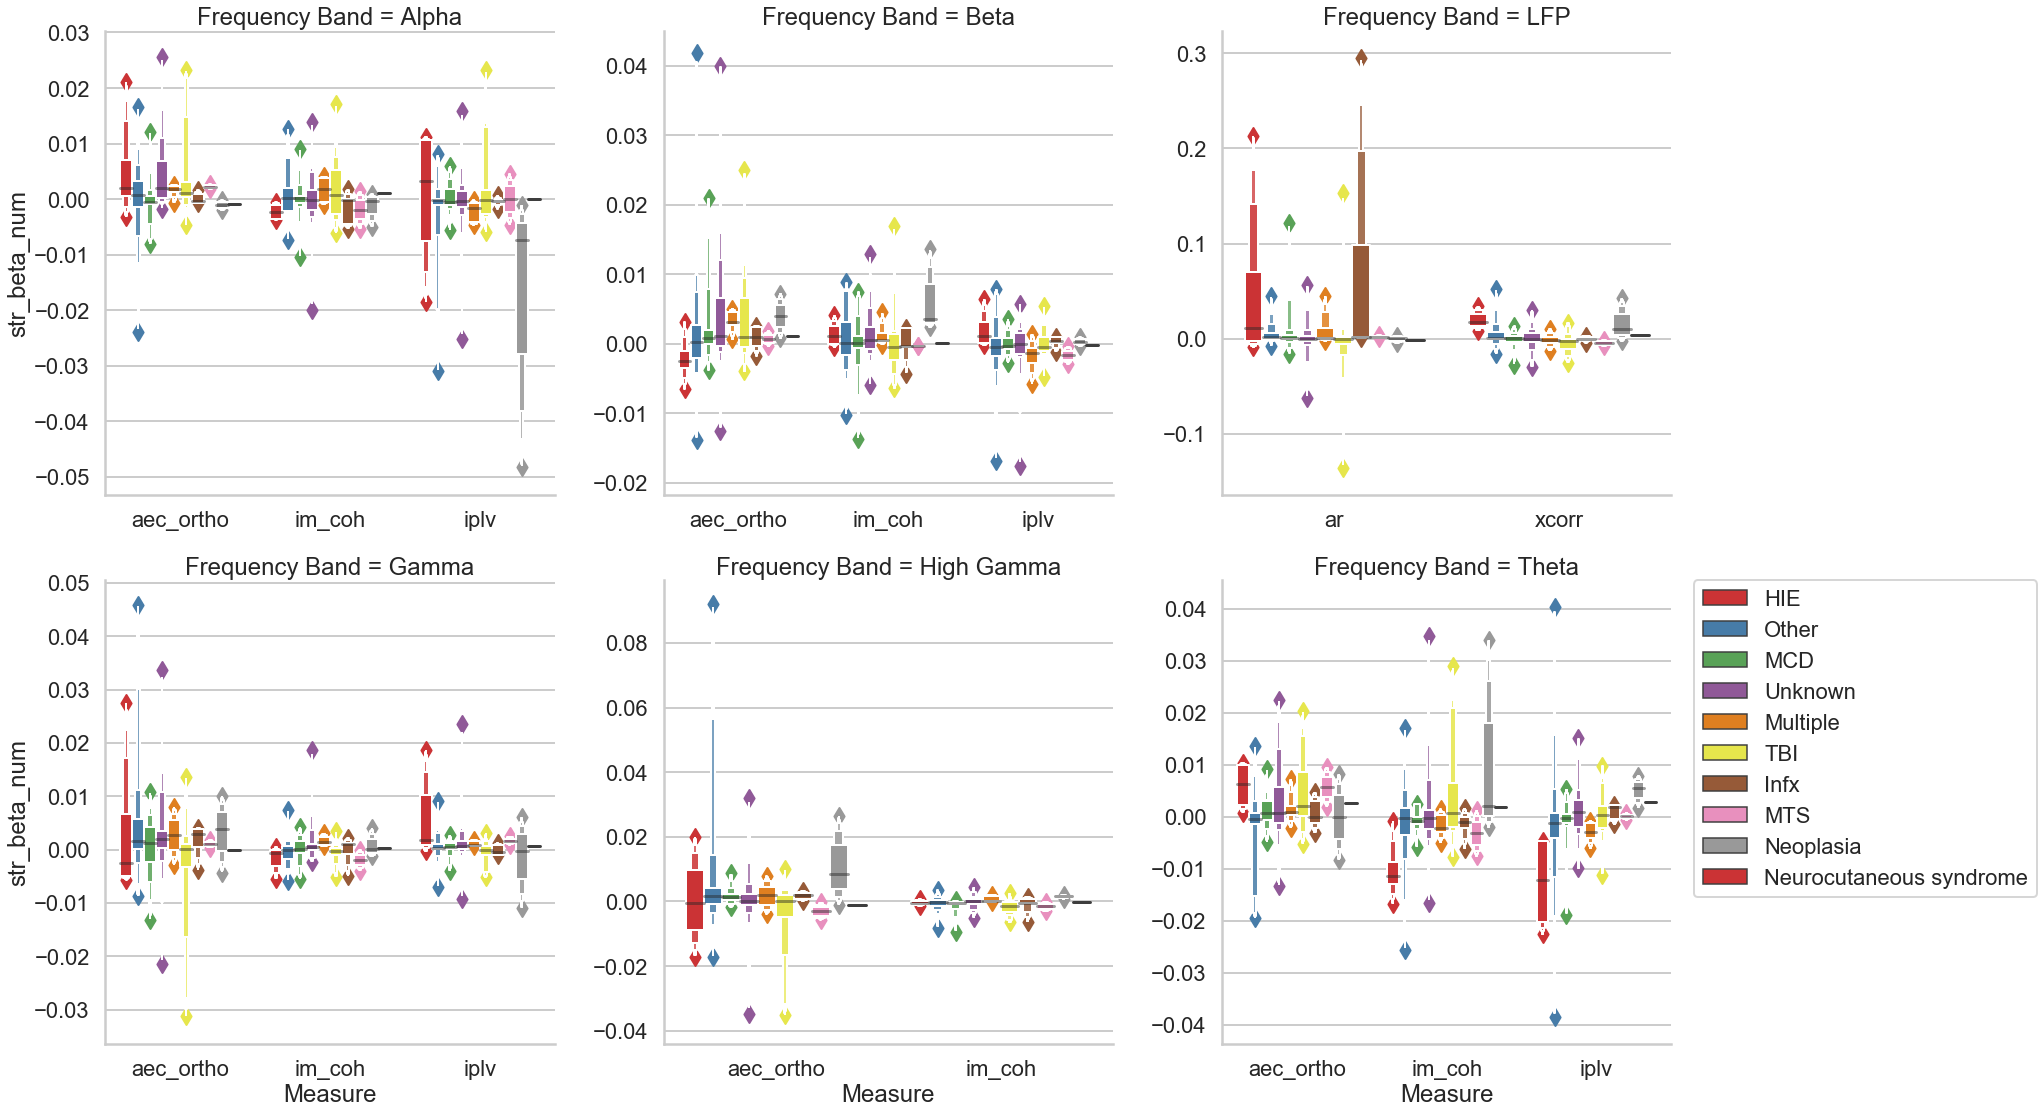

In [634]:
yvar = 'num'
g = sns.FacetGrid(data=net_data[(net_data['Measure'] != 'aec') & (net_data['Measure'] != 'coh') & (net_data['Measure'] != 'plv')], 
                  col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8)
g.map(sns.boxenplot, 'Measure', 'str_beta_' + yvar, 'Etiology', palette='Set1')
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
g.savefig(f'../img/etiology_{yvar}.pdf')

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the boxenplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


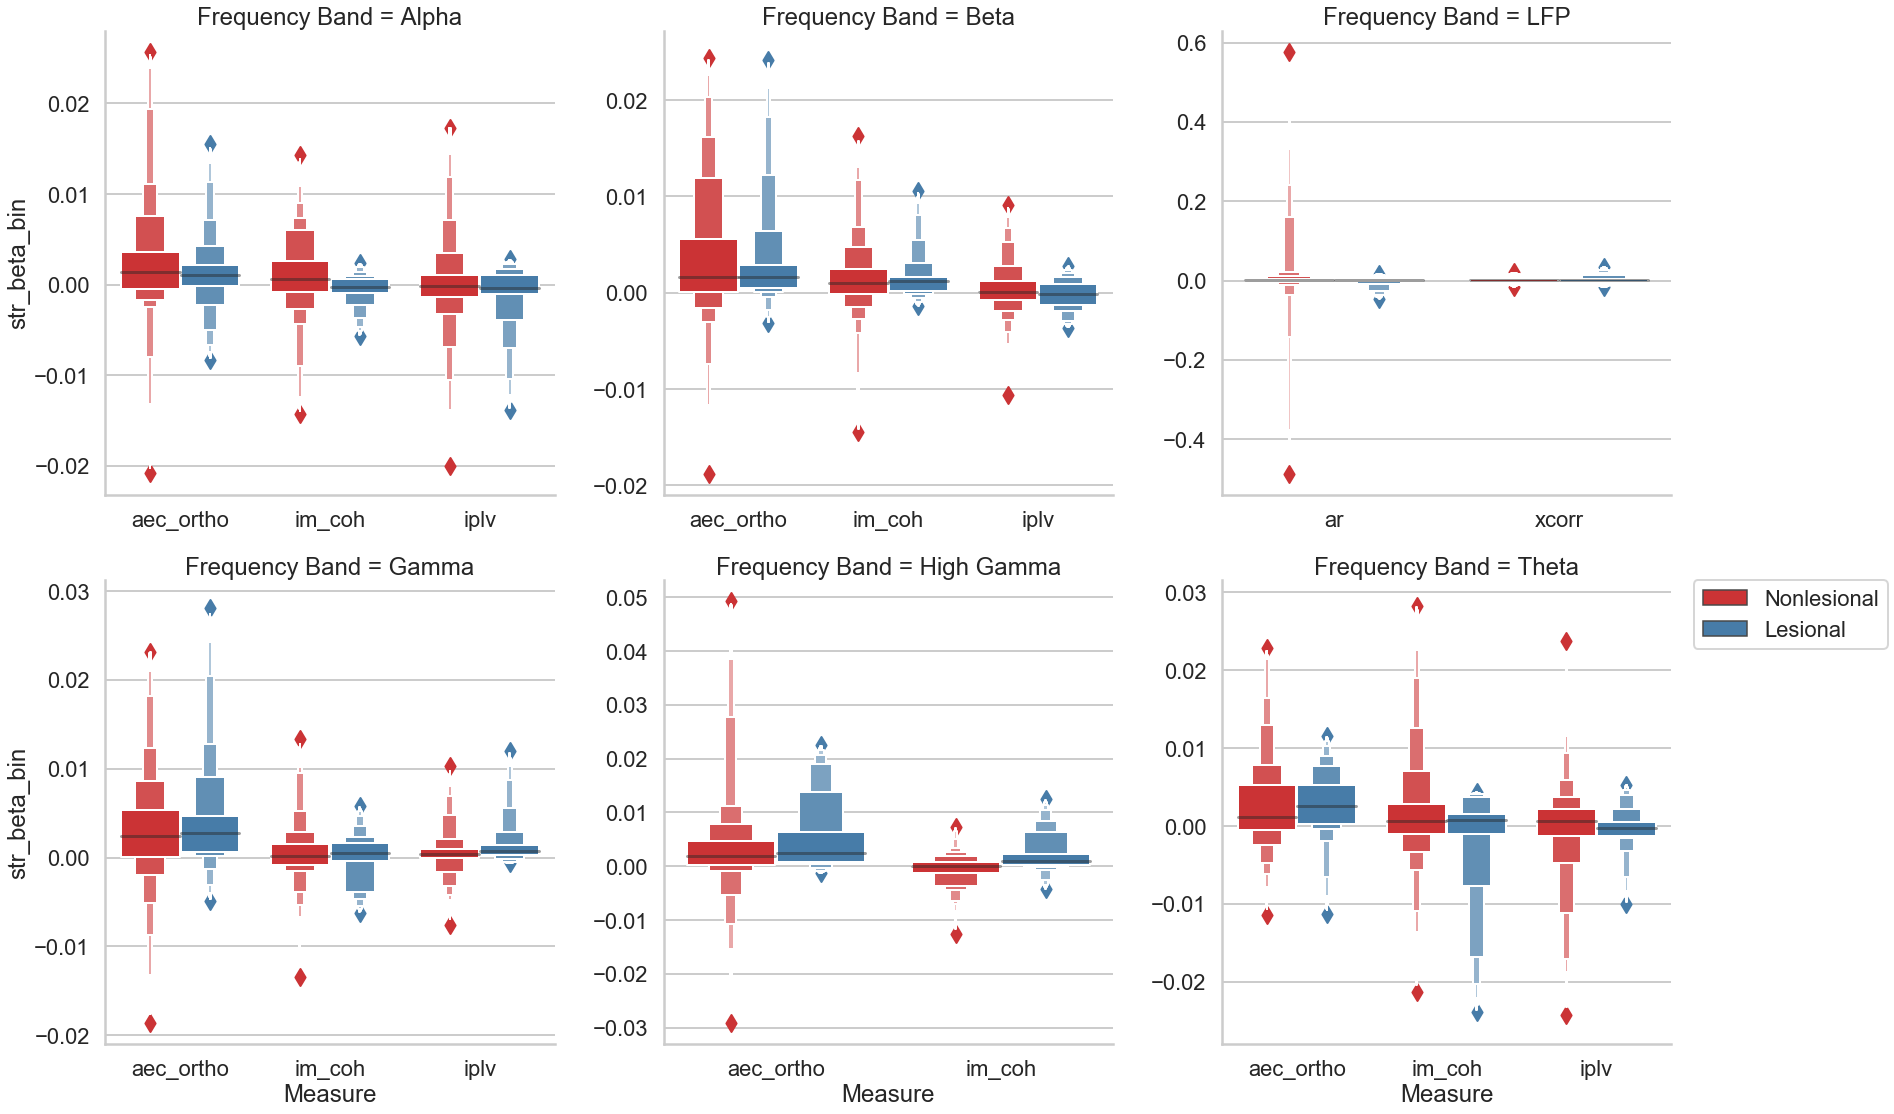

In [635]:
yvar = 'spr'
g = sns.FacetGrid(data=net_data[(net_data['Measure'] != 'aec') & (net_data['Measure'] != 'coh')], col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8)
g.map(sns.boxenplot, 'Measure', 'str_beta_bin', 'Lesional', palette='Set1')
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
g.savefig(f'../img/lesional_{yvar}.pdf')

### Categorize SOZ

In [636]:
# check labels of elecs in soz for which sys they are in
flag = 'spike' # spike or soz

epilepsy_type = pd.DataFrame(data={'subj':net_data.subj.unique(), 
                                   'locus':np.empty(net_data.subj.unique().shape),
                                  'hem':np.empty(net_data.subj.unique().shape)})
for index,row in epilepsy_type.iterrows():
    if flag == 'spike':
        curr = node_data[(node_data['subj'] == row.subj)]
        curr = curr[curr['elec_spike'] == curr['elec_spike'].max()]    
    else:
        curr = node_data[(node_data['subj'] == row.subj) & (node_data['elec_in_soz'] == 1)]
    if (np.shape(curr)[0] == 0):
        epilepsy_type.loc[index, 'locus'] = np.nan
        epilepsy_type.loc[index,'hem'] = np.nan
    else:
        epilepsy_type.loc[index,'locus'] = curr.sys.mode()[0]
        epilepsy_type.loc[index, 'hem']= curr.hem.mode()[0]
    
epilepsy_type.head()           

subj    locus  hem
0  R1170J   SomMot   LH
1  R1291M      NaN  NaN
2  R1284N  Default   LH
3  R1285C      NaN  NaN
4  R1283T      NaN  NaN

In [637]:
node_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225120 entries, 0 to 2132129
Data columns (total 43 columns):
elec                      225120 non-null object
band_measure              225120 non-null object
n_tp                      225120 non-null int64
elec_spike                225120 non-null float64
elec_in_soz               225120 non-null int64
scale_spr                 189120 non-null float64
scale_bin                 175740 non-null float64
scale_num                 189120 non-null float64
str_soz_beta_bin          158850 non-null float64
str_not_soz_beta_bin      144850 non-null float64
str_spike_beta_bin        158190 non-null float64
str_not_spike_beta_bin    138468 non-null float64
str_beta_bin              221910 non-null float64
str_soz_beta_num          159750 non-null float64
str_not_soz_beta_num      145724 non-null float64
str_spike_beta_num        159210 non-null float64
str_beta_num              223050 non-null float64
str_not_spike_beta_num    139628 non-null fl

In [638]:
epilepsy_type.dropna().subj.nunique()

106

In [639]:
node_data.region.unique()

array(['inferiorparietal', 'supramarginal', 'superiortemporal',
       'bankssts', 'middletemporal', 'inferiortemporal',
       'lateraloccipital', 'fusiform', 'temporalpole', 'insula',
       'rostralmiddlefrontal', 'lateralorbitofrontal', nan,
       'transversetemporal', 'caudalanteriorcingulate', 'superiorfrontal',
       'parahippocampal', 'entorhinal', 'parsorbitalis',
       'parstriangularis', 'precuneus', 'medialorbitofrontal',
       'parsopercularis', 'precentral', 'postcentral',
       'rostralanteriorcingulate', 'posteriorcingulate',
       'caudalmiddlefrontal', 'superiorparietal', 'paracentral',
       'isthmuscingulate', 'lingual', 'cuneus', 'pericalcarine',
       'frontalpole'], dtype=object)

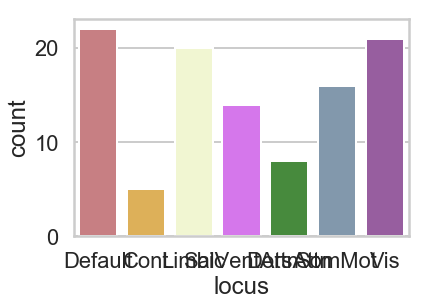

In [640]:
sns.countplot(data=epilepsy_type, x='locus', palette = sys_pal, 
              order = ['Default', 'Cont','Limbic', 'SalVentAttn','DorsAttn', 'SomMot','Vis'],
             hue_order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'])

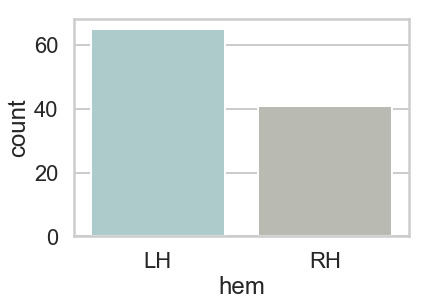

In [641]:
sns.countplot(data=epilepsy_type, x='hem')

In [642]:
# add locus back to big data frames
#net_data.drop(['locus', 'hem'],axis=1,inplace=True)
net_data = pd.merge(net_data, epilepsy_type, on='subj',how='outer')
#node_data = pd.merge(node_data, epilepsy_type, on='subj')
net_data.head()

band_measure  n_tp  str_beta_bin  str_beta_num  str_beta_spr  \
0  alpha_aec_ortho   107      0.003289      0.001749     -0.000120   
1     alpha_im_coh   107     -0.002251     -0.001216     -0.000052   
2       alpha_iplv   107     -0.011551     -0.018571     -0.000731   
3   beta_aec_ortho   107      0.000570     -0.002487      0.000517   
4      beta_im_coh   107      0.002699      0.002134      0.000615   

   ti_beta_bin  ti_beta_num  ti_beta_spr  str_soz_beta_bin  str_soz_beta_num  \
0    -0.038618    -0.040827    -0.004130          0.010050          0.014568   
1     0.007866     0.010105    -0.000839         -0.006486         -0.006336   
2     0.035004     0.052945     0.002363         -0.017375         -0.029580   
3     0.008797     0.038698     0.000097         -0.002593         -0.001835   
4    -0.019914    -0.036505    -0.007572          0.001734          0.000889   

  ...   type  contacts     Lesional  Institution     Ethnicity  Education  \
0 ...    [D]         D  Nonlesional         Jeff  Non-Hispanic       12.0   
1 ...    [D]         D  Nonlesional         Jeff  Non-Hispanic       12.0   
2 ...    [D]         D  Nonlesional         Jeff  Non-Hispanic       12.0   
3 ...    [D]         D  Nonlesional         Jeff  Non-Hispanic       12.0   
4 ...    [D]         D  Nonlesional         Jeff  Non-Hispanic       12.0   

   SeizureAge  Etiology   locus  hem  
0         8.5       HIE  SomMot   LH  
1         8.5       HIE  SomMot   LH  
2         8.5       HIE  SomMot   LH  
3         8.5       HIE  SomMot   LH  
4         8.5       HIE  SomMot   LH  

[5 rows x 38 columns]

In [643]:
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2320 entries, 0 to 2319
Data columns (total 38 columns):
band_measure              2320 non-null object
n_tp                      2320 non-null int64
str_beta_bin              2268 non-null float64
str_beta_num              2278 non-null float64
str_beta_spr              2267 non-null float64
ti_beta_bin               2268 non-null float64
ti_beta_num               2273 non-null float64
ti_beta_spr               2272 non-null float64
str_soz_beta_bin          1621 non-null float64
str_soz_beta_num          1645 non-null float64
str_soz_beta_spr          1645 non-null float64
str_not_soz_beta_num      1638 non-null float64
str_spike_beta_num        1583 non-null float64
str_not_soz_beta_spr      1632 non-null float64
str_not_soz_beta_bin      1610 non-null float64
str_spike_beta_bin        1565 non-null float64
str_spike_beta_spr        1585 non-null float64
str_not_spike_beta_bin    1549 non-null float64
Measure                   2320 n

In [644]:
net_data.subj.nunique()

143

## Net plots with category by locus

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


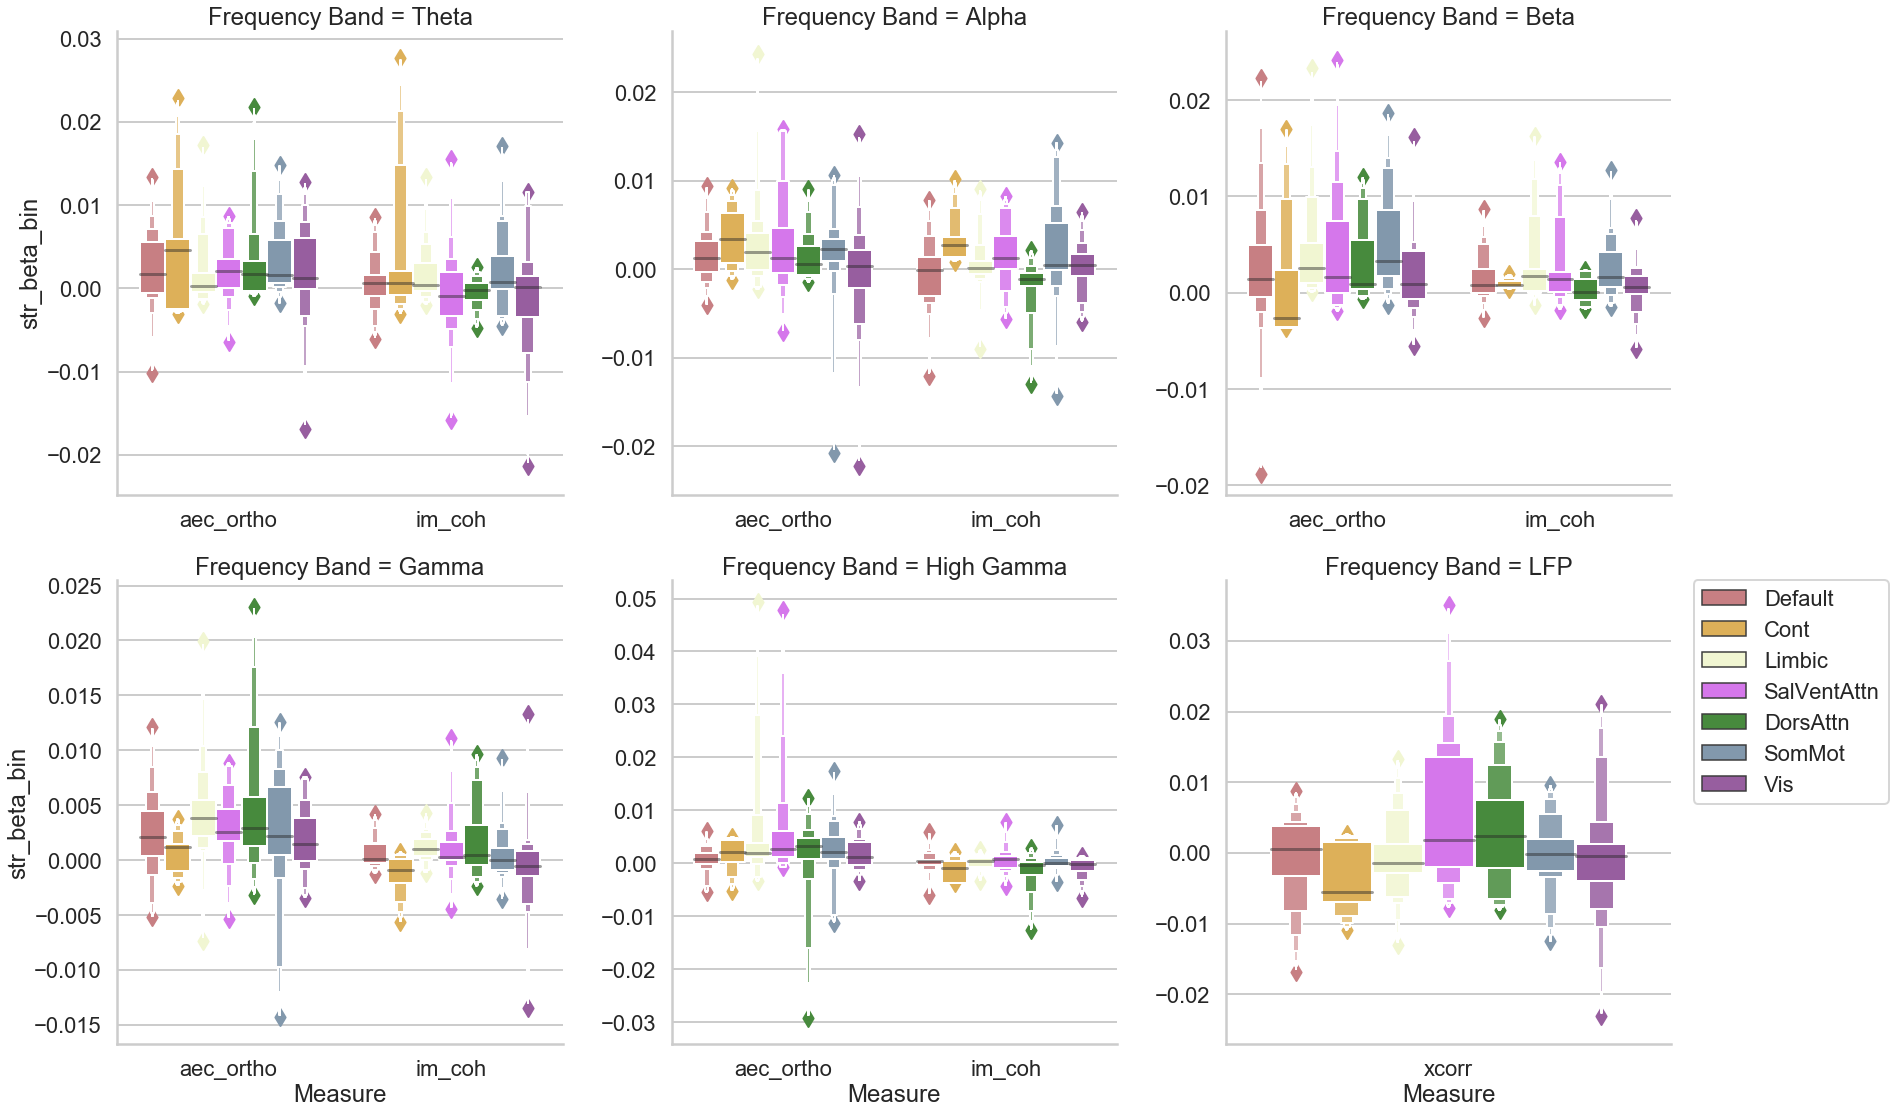

In [645]:
yvar = 'bin'
g = sns.FacetGrid(data=net_data[(net_data.Measure != 'aec') & (net_data.Measure != 'coh') & 
                                (net_data.Measure != 'plv') & (net_data.Measure != 'iplv') & (net_data.Measure != 'ar')], col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8, col_order = ['Theta', 'Alpha', 'Beta', 'Gamma','High Gamma', 'LFP'])
g.map(sns.boxenplot, 'Measure', 'str_beta_' + yvar, 'locus', palette = sys_pal, 
      hue_order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'])
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
#for ax in g.axes:
#    ax.set_ylim(-5,5)
    
g.savefig(f'../img/soz_region_{yvar}{detector}.pdf')

In [646]:
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/sys_{flag}{detector}.csv')

## Behavior

In [647]:
task_data = pd.read_csv(f'{RAM_dir}group_analysis/task_performance.csv', index_col=0)
task_data.reset_index(inplace=True)
task_data.head(10)

subj        YC  TH       PAL  catFR        FR
0  R1001P  0.345526 NaN  0.041370    NaN  0.546573
1  R1002P       NaN NaN  0.492335    NaN  0.945857
2  R1003P       NaN NaN  0.083711    NaN  0.602817
3  R1004D       NaN NaN       NaN  0.625       NaN
4  R1006P  0.401778 NaN       NaN    NaN  0.779412
5  R1008J  0.530724 NaN       NaN    NaN       NaN
6  R1009W  0.183700 NaN       NaN    NaN       NaN
7  R1010J  0.358207 NaN       NaN    NaN  0.825373
8  R1013E  0.182021 NaN       NaN    NaN       NaN
9  R1014D  0.354468 NaN       NaN    NaN       NaN

In [648]:
# count missing values
task_data.apply(lambda x: sum(x.isnull())/x.size*100, axis=0)

subj      0.000000
YC       78.597786
TH       86.715867
PAL      76.014760
catFR    62.730627
FR       40.959410
dtype: float64

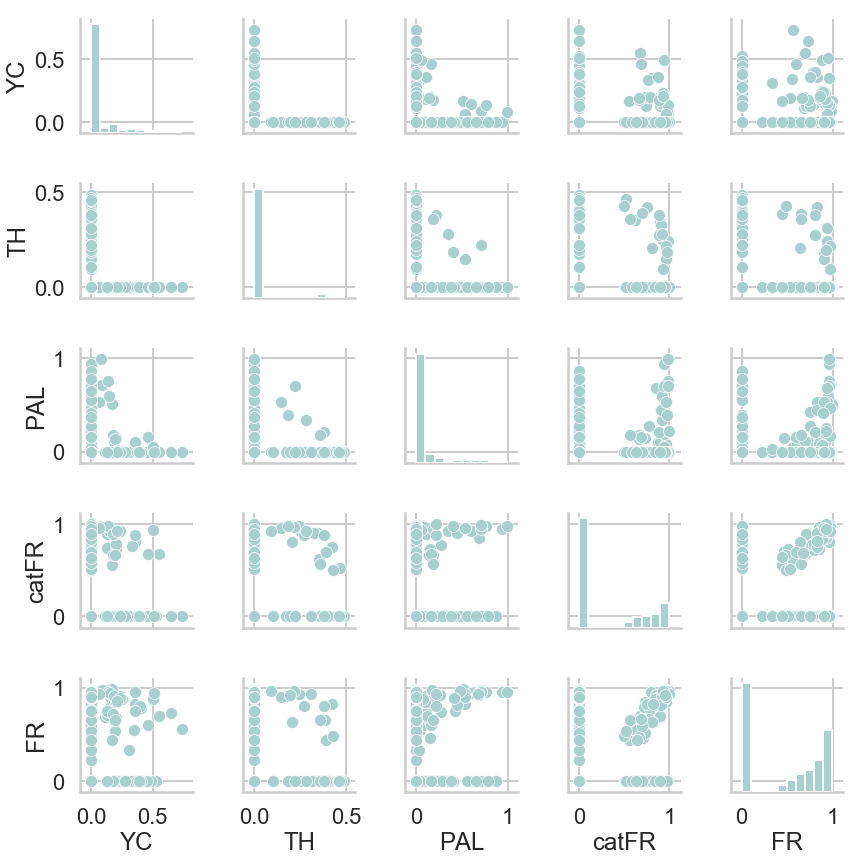

In [649]:
sns.pairplot(data=task_data.fillna(0), vars=['YC','TH','PAL','catFR','FR'])

In [650]:
# add averages over recal and nav tasks
task_data = task_data.assign(recall = task_data[['catFR','FR','PAL']].mean(axis=1, skipna=True))
task_data = task_data.assign(nav = task_data[['TH','YC']].mean(axis=1, skipna=True))
task_data = task_data.assign(scale_nav =  1 - task_data['nav'])
task_data = task_data.assign(avg = task_data[['scale_nav','recall']].mean(axis=1, skipna=True))
task_data.head()

subj        YC  TH       PAL  catFR        FR    recall       nav  \
0  R1001P  0.345526 NaN  0.041370    NaN  0.546573  0.293972  0.345526   
1  R1002P       NaN NaN  0.492335    NaN  0.945857  0.719096       NaN   
2  R1003P       NaN NaN  0.083711    NaN  0.602817  0.343264       NaN   
3  R1004D       NaN NaN       NaN  0.625       NaN  0.625000       NaN   
4  R1006P  0.401778 NaN       NaN    NaN  0.779412  0.779412  0.401778   

   scale_nav       avg  
0   0.654474  0.474223  
1        NaN  0.719096  
2        NaN  0.343264  
3        NaN  0.625000  
4   0.598222  0.688817

In [651]:
# count missing values again
task_data.apply(lambda x: sum(x.isnull())/x.size*100, axis=0)

subj          0.000000
YC           78.597786
TH           86.715867
PAL          76.014760
catFR        62.730627
FR           40.959410
recall       18.819188
nav          65.313653
scale_nav    65.313653
avg           8.487085
dtype: float64

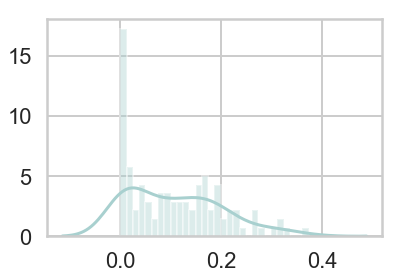

In [652]:
# Are subjects variable across tasks? 
var = pd.core.nanops.nanvar(task_data[['TH', 'YC', 'PAL', 'FR', 'catFR']], axis=1)
var = var[task_data[['TH', 'YC', 'PAL', 'FR', 'catFR']].isna().sum(axis=1) <= 3]
sns.distplot(var, bins=30)

In [653]:
# merge with net_data
subj_idx = [x in net_data.subj.unique() for x in task_data.subj]
task_data = task_data[subj_idx]
net_data = pd.merge(net_data, task_data, on=['subj'], how = 'outer')
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2720 entries, 0 to 2719
Data columns (total 47 columns):
band_measure              2720 non-null object
n_tp                      2720 non-null int64
str_beta_bin              2665 non-null float64
str_beta_num              2677 non-null float64
str_beta_spr              2654 non-null float64
ti_beta_bin               2665 non-null float64
ti_beta_num               2673 non-null float64
ti_beta_spr               2670 non-null float64
str_soz_beta_bin          1844 non-null float64
str_soz_beta_num          1884 non-null float64
str_soz_beta_spr          1883 non-null float64
str_not_soz_beta_num      1878 non-null float64
str_spike_beta_num        1774 non-null float64
str_not_soz_beta_spr      1868 non-null float64
str_not_soz_beta_bin      1833 non-null float64
str_spike_beta_bin        1738 non-null float64
str_spike_beta_spr        1776 non-null float64
str_not_spike_beta_bin    1724 non-null float64
Measure                   2720 n

In [654]:
net_data.subj.nunique()

143

In [655]:
# save
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_task_data_clean{detector}.csv')

## Demographics

In [656]:
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2720 entries, 0 to 2719
Data columns (total 47 columns):
band_measure              2720 non-null object
n_tp                      2720 non-null int64
str_beta_bin              2665 non-null float64
str_beta_num              2677 non-null float64
str_beta_spr              2654 non-null float64
ti_beta_bin               2665 non-null float64
ti_beta_num               2673 non-null float64
ti_beta_spr               2670 non-null float64
str_soz_beta_bin          1844 non-null float64
str_soz_beta_num          1884 non-null float64
str_soz_beta_spr          1883 non-null float64
str_not_soz_beta_num      1878 non-null float64
str_spike_beta_num        1774 non-null float64
str_not_soz_beta_spr      1868 non-null float64
str_not_soz_beta_bin      1833 non-null float64
str_spike_beta_bin        1738 non-null float64
str_spike_beta_spr        1776 non-null float64
str_not_spike_beta_bin    1724 non-null float64
Measure                   2720 n

In [657]:
# add institution
def get_inst(subj):
    if subj[-1] == 'J':
        net_data[net_data['subj'] == subj]['Institution'] = 'Jeff'
    elif subj[-1] == 'P':
        net_data[net_data['subj'] == subj]['Institution'] = 'Penn'
    elif subj[-1] == 'M':
        net_data[net_data['subj'] == subj]['Institution'] = 'Mayo'
    elif subj[-1] == 'C':
        net_data[net_data['subj'] == subj]['Institution'] = 'Columbia'
    elif subj[-1] == 'E':
        net_data[net_data['subj'] == subj]['Institution'] = 'Emory'
    elif subj[-1] == 'D':
        net_data[net_data['subj'] == subj]['Institution'] = 'Dartmouth'
    elif subj[-1] == 'N':
        net_data[net_data['subj'] == subj]['Institution'] = 'NINDS'
    else:
        net_data.loc[net_data['subj'] == subj,'Institution'] = subj[-1]
        
for s in net_data[net_data['Institution'].isna()]['subj'].values:
    get_inst(s)

In [658]:
sum(net_data['Institution'].isna())

0

In [659]:
print('Etiology: ' + str(net_data[[not x for x in net_data['Etiology'].isna()]]['subj'].nunique()/net_data.subj.nunique()))
print('Education: ' + str(net_data[[not x for x in net_data['Education'].isna()]]['subj'].nunique()/net_data.subj.nunique()))
print('Institution: ' + str(net_data[[not x for x in net_data['Institution'].isna()]]['subj'].nunique()/net_data.subj.nunique()))
print('Lesional: ' + str(net_data[[not x for x in net_data['Lesional'].isna()]]['subj'].nunique()/net_data.subj.nunique()))
print('SeizureAge: ' + str(net_data[[not x for x in net_data['SeizureAge'].isna()]]['subj'].nunique()/net_data.subj.nunique()))
print('locus: ' + str(net_data[[not x for x in net_data['locus'].isna()]]['subj'].nunique()/net_data.subj.nunique()))
print('hem: ' + str(net_data[[not x for x in net_data['hem'].isna()]]['subj'].nunique()/net_data.subj.nunique()))
print('avg: ' + str(net_data[[not x for x in net_data['avg'].isna()]]['subj'].nunique()/net_data.subj.nunique()))


Etiology: 0.7902097902097902
Education: 0.6433566433566433
Institution: 1.0
Lesional: 0.8671328671328671
SeizureAge: 0.8391608391608392
locus: 0.7412587412587412
hem: 0.7412587412587412
avg: 0.972027972027972


In [660]:
# add most common etiology (unkown) and education to missing data
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2720 entries, 0 to 2719
Data columns (total 47 columns):
band_measure              2720 non-null object
n_tp                      2720 non-null int64
str_beta_bin              2665 non-null float64
str_beta_num              2677 non-null float64
str_beta_spr              2654 non-null float64
ti_beta_bin               2665 non-null float64
ti_beta_num               2673 non-null float64
ti_beta_spr               2670 non-null float64
str_soz_beta_bin          1844 non-null float64
str_soz_beta_num          1884 non-null float64
str_soz_beta_spr          1883 non-null float64
str_not_soz_beta_num      1878 non-null float64
str_spike_beta_num        1774 non-null float64
str_not_soz_beta_spr      1868 non-null float64
str_not_soz_beta_bin      1833 non-null float64
str_spike_beta_bin        1738 non-null float64
str_spike_beta_spr        1776 non-null float64
str_not_spike_beta_bin    1724 non-null float64
Measure                   2720 n

In [661]:
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_dem_data{detector}.csv')

In [662]:
net_data.subj.nunique()

143